In [1]:
import os
import pandas as pd
#1~9호선 전체역별 모델을 제작하고자 하였으나 지하철 승하차 데이터에 전체역이 나와있지 않아 2019년 5월 기준 가장 많은 승하차 인원 top4와
#추가적으로 서울의 대표적 나들이 장소와 가까운 역 4군데를 선정하였다. 이태원 같은 경우는 코로나 확진으로 많은 피해를 받는 구이기 때문에
#포함시켜보았다.
import seaborn as sns
import matplotlib
import matplotlib.dates as md
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
import tensorflow as tf
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
#한글
!apt-get install fonts-nanum*
!apt-get install fontconfig
!fc-cache -fv
!cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm -rf /content/.cache/matplotlib/*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 32 not upgraded.
Need to get 37.0 MB of archives.
After this operation, 145 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-eco all 1.000-6 [14.0 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-extra all 20170925-1 [12.2 MB]
Get:4 http://archive.ubu

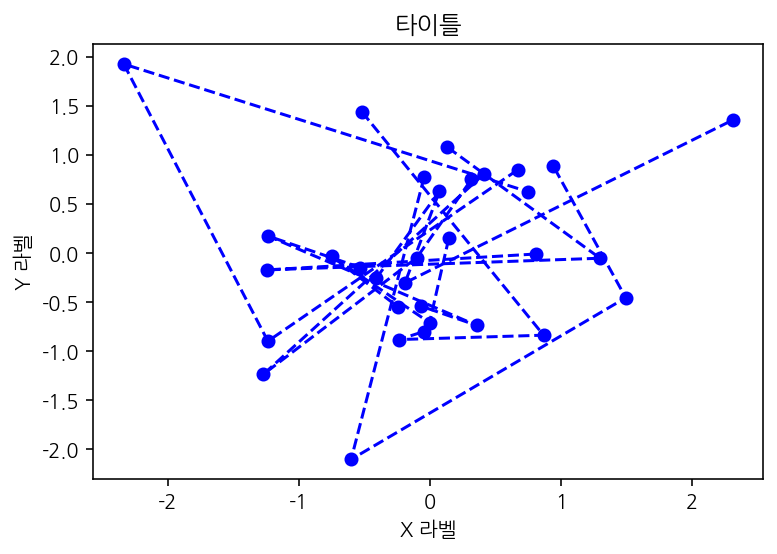

In [ ]:
  import matplotlib.pyplot as plt
  import matplotlib as mpl
  import matplotlib.font_manager as fm
  import numpy as np
  %matplotlib inline
  %config InlineBackend.figure_format = 'retina'
	
  mpl.rcParams['axes.unicode_minus'] = False
  # 그래프에서 마이너스 폰트 깨질 경우 대비
	
  path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
  font_name = fm.FontProperties(fname=path, size=18).get_name()
  plt.rc('font', family=font_name)
  fm._rebuild() # 이걸 해줘야 plt.rc가 작동

  plt.plot(np.random.randn(4, 8), np.random.randn(4,8), 'bo--')
  plt.title('타이틀')
  plt.xlabel('X 라벨')
  plt.ylabel('Y 라벨')
  plt.show()
	


In [3]:
#2020년 5월 승하차 데이터
df_2005 = pd.read_csv('CARD_SUBWAY_MONTH_202005.csv',encoding='CP949')
df_2005 = df_2005[df_2005['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_2005 = df_2005[df_2005['사용일자'] >= 20200501]
df_2005 = df_2005[df_2005['호선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_2005 = df_2005.rename(columns={'호선명':'노선명'})
#2020년 4월 승하차 데이터
df_2004 = pd.read_csv('CARD_SUBWAY_MONTH_202004.csv')
df_2004 = df_2004[df_2004['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_2004 = df_2004[df_2004['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_2004 = df_2004.drop(['역ID','등록일자'], axis=1)
#2020년 3월 승하차 데이터
df_2003 = pd.read_csv('CARD_SUBWAY_MONTH_202003.csv')
df_2003 = df_2003[df_2003['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_2003 = df_2003[df_2003['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_2003 = df_2003.drop(['역ID','등록일자'], axis=1)
#2020년 2월 승하차 데이터
df_2002 = pd.read_csv('CARD_SUBWAY_MONTH_202002.csv')
df_2002 = df_2002[df_2002['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_2002 = df_2002[df_2002['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_2002 = df_2002.drop(['역ID','등록일자'], axis=1)
#2020년 1월 승하차 데이터    * 1월 15일 우한에서 코로나바이러스 확산 시작
df_2001 = pd.read_excel('CARD_SUBWAY_MONTH_202001_1.xlsx')
df_2001 = df_2001[df_2001['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_2001 = df_2001[df_2001['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_2001 = df_2001.drop(['역ID','등록일자'], axis=1)
#2019년 12월 승하차 데이터
df_1912 = pd.read_csv('CARD_SUBWAY_MONTH_201912.csv',encoding='CP949')
df_1912 = df_1912[df_1912['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1912 = df_1912[df_1912['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1912 = df_1912.drop(['역ID','등록일자'], axis=1)
#2019년 11월 승하차 데이터
df_1911 = pd.read_csv('CARD_SUBWAY_MONTH_201911.csv',encoding='CP949')
df_1911 = df_1911[df_1911['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1911 = df_1911[df_1911['호선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1911 = df_1911.drop(['역ID','등록일자'], axis=1)
df_1911 = df_1911.rename(columns={'호선명':'노선명'})
#2019년 10월 승하차 데이터
df_1910 = pd.read_csv('CARD_SUBWAY_MONTH_201910.csv')
df_1910 = df_1910[df_1910['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1910 = df_1910[df_1910['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1910 = df_1910.drop(['역ID','등록일자'], axis=1)
#2019년 9월 승하차 데이터
df_1909 = pd.read_csv('CARD_SUBWAY_MONTH_201909.csv')
df_1909 = df_1909[df_1909['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1909 = df_1909[df_1909['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1909 = df_1909.drop(['역ID','등록일자'], axis=1)
#2019년 8월 승하차 데이터
df_1908 = pd.read_csv('CARD_SUBWAY_MONTH_201908.csv')
df_1908 = df_1908[df_1908['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1908 = df_1908[df_1908['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1908 = df_1908.drop(['역ID','등록일자'], axis=1)
#2019년 7월 승하차 데이터
df_1907 = pd.read_csv('CARD_SUBWAY_MONTH_201907.csv')
df_1907 = df_1907[df_1907['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1907 = df_1907[df_1907['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1907 = df_1907.drop(['역ID','등록일자'], axis=1)
#2019년 6월 승하차 데이터
df_1906 = pd.read_csv('CARD_SUBWAY_MONTH_201906.csv')
df_1906 = df_1906[df_1906['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1906 = df_1906[df_1906['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1906 = df_1906.drop(['역ID','등록일자'], axis=1)
#2019년 5월 승하차 데이터
df_1905 = pd.read_csv('CARD_SUBWAY_MONTH_201905.csv')
df_1905 = df_1905[df_1905['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1905 = df_1905[df_1905['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1905 = df_1905.drop(['역ID','등록일자'], axis=1)
#2019년 4월 승하차 데이터
df_1904 = pd.read_csv('CARD_SUBWAY_MONTH_201904.csv')
df_1904 = df_1904[df_1904['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1904 = df_1904[df_1904['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1904 = df_1904.drop(['역ID','등록일자'], axis=1)
#2019년 3월 승하차 데이터
df_1903 = pd.read_csv('CARD_SUBWAY_MONTH_201903.csv')
df_1903 = df_1903[df_1903['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1903 = df_1903[df_1903['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1903 = df_1903.drop(['역ID','등록일자'], axis=1)
#2019년 2월 승하차 데이터
df_1902 = pd.read_csv('CARD_SUBWAY_MONTH_201902.csv')
df_1902 = df_1902[df_1902['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1902 = df_1902[df_1902['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1902 = df_1902.drop(['역ID','등록일자'], axis=1)
#2019년 1월 승하차 데이터
df_1901 = pd.read_csv('CARD_SUBWAY_MONTH_201901.csv')
df_1901 = df_1901[df_1901['역명'].isin(['강남','잠실(송파구청)','홍대입구','고속터미널','이태원','여의나루','건대입구','명동'])]
df_1901 = df_1901[df_1901['노선명'].isin(['2호선','3호선','4호선','5호선','6호선'])]
df_1901 = df_1901.drop(['역ID','등록일자'], axis=1)
df_2001

FileNotFoundError: ignored

In [ ]:
metro = pd.concat([df_2005,df_2004,df_2003,df_2002,df_2001,df_1912,df_1911,df_1910,df_1909,df_1908,df_1907,df_1906,df_1905,df_1904,df_1903,df_1902,df_1901])
metro

,사용일자,노선명,역명,승차총승객수,하차총승객수
400,20200518,6호선,이태원,5716,5660
454,20200518,5호선,여의나루,7331,7448
482,20200518,4호선,명동,15215,16212
511,20200518,3호선,고속터미널,34099,32244
542,20200518,2호선,홍대입구,36736,37459
559,20200518,2호선,강남,82693,81923
565,20200518,2호선,잠실(송파구청),58039,57359
569,20200518,2호선,건대입구,29461,31128
993,20200517,6호선,이태원,3528,3396
1046,20200517,5호선,여의나루,7471,7376


In [ ]:
#지하철역 주소 데이터 알맞게 전처리
address = pd.read_excel('address.xlsx',header=1)
address = address[['역명','구']]
address = address.drop_duplicates(subset=["역명"], keep='last')
address

,역명,구
0,서울,중구
2,종각,종로구
4,종로5가,종로구
7,제기동,동대문구
8,청량리(서울시립대입구),동대문구
10,시청,중구
11,을지로입구,중구
16,상왕십리,성동구
18,한양대,성동구
19,뚝섬,성동구


In [ ]:
#지하철역 승하차 데이터와 주소 데이터 합치기
address_2005 = pd.merge(left = metro,
        right = address,
        how = 'left',
        left_on = '역명',
        right_on = '역명')
address_2005.rename(columns={'사용일자':'일시'},inplace=True)
address_2005
address_2005.isna().sum()
address_2005['일시'] = address_2005['일시'].astype(int)

In [ ]:
#날씨 데이터 : 지하철데이터와 합치기전에 알맞게 전처리
weather = pd.read_csv('OBS_AWS_DD_20200526225701.csv',encoding='CP949')
weather.replace({'광진':'광진구','마포':'마포구','서초':'서초구','송파':'송파구','영등포 ':'영등포구','용산':'용산구'},inplace=True)
weather.rename(columns={'지점명':'구'},inplace=True)
weather

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s)
0,강남,20190101,-3.7,0.0,1.8
1,강남,20190102,-3.5,0.0,1.5
2,강남,20190103,-1.9,0.0,1.1
3,강남,20190104,-0.5,0.0,1.3
4,강남,20190105,-1.5,0.0,2.0
5,강남,20190106,-1.6,0.0,1.3
6,강남,20190107,-0.7,0.0,1.4
7,강남,20190108,-2.3,0.0,2.0
8,강남,20190109,-3.6,0.0,1.3
9,강남,20190110,0.0,0.0,1.3


In [ ]:
#날씨와 지하철 데이터 합치기
weather_add = pd.merge(weather, address_2005, how='outer')
weather_add

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승차총승객수,하차총승객수
0,강남,20190101,-3.7,0.0,1.8,2호선,강남,38729,36544
1,강남,20190102,-3.5,0.0,1.5,2호선,강남,116550,116482
2,강남,20190103,-1.9,0.0,1.1,2호선,강남,122254,122889
3,강남,20190104,-0.5,0.0,1.3,2호선,강남,129878,134948
4,강남,20190105,-1.5,0.0,2.0,2호선,강남,90030,95814
5,강남,20190106,-1.6,0.0,1.3,2호선,강남,52313,51169
6,강남,20190107,-0.7,0.0,1.4,2호선,강남,121527,121092
7,강남,20190108,-2.3,0.0,2.0,2호선,강남,123559,123099
8,강남,20190109,-3.6,0.0,1.3,2호선,강남,123657,122365
9,강남,20190110,0.0,0.0,1.3,2호선,강남,124860,124336


In [ ]:
#결측치 확인
weather_add.isna().sum()

구              0
일시             0
평균기온(°C)      30
일강수량(mm)       8
평균 풍속(m/s)    27
노선명            0
역명             0
승차총승객수         0
하차총승객수         0
dtype: int64

In [ ]:
#***********주의******************                                  실행(Run) XXXXXX
#여기서 실행시키지 말것(파일이 저장되어있기 떄문에)
#평균기온은 네이버에서 확인 후 입력하여 결측치 처리하기 위해 파일 저장
weather_add.to_csv('weather_add.csv', encoding = 'CP949')
#강수량과 평균풍속은 데이터가 안 나와있어서 앞,뒤 중간값(평균값으로 대체)
weather_add.interpolate(axis=0, inplace=True)
weather_add_1.to_csv('weather_add.csv', encoding = 'CP949')

,Unnamed: 0,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승차총승객수,하차총승객수
0,0,강남,20190101,-3.7,0.0,1.8,2호선,강남,38729,36544
1,1,강남,20190102,-3.5,0.0,1.5,2호선,강남,116550,116482
2,2,강남,20190103,-1.9,0.0,1.1,2호선,강남,122254,122889
3,3,강남,20190104,-0.5,0.0,1.3,2호선,강남,129878,134948
4,4,강남,20190105,-1.5,0.0,2.0,2호선,강남,90030,95814
5,5,강남,20190106,-1.6,0.0,1.3,2호선,강남,52313,51169
6,6,강남,20190107,-0.7,0.0,1.4,2호선,강남,121527,121092
7,7,강남,20190108,-2.3,0.0,2.0,2호선,강남,123559,123099
8,8,강남,20190109,-3.6,0.0,1.3,2호선,강남,123657,122365
9,9,강남,20190110,0.0,0.0,1.3,2호선,강남,124860,124336


In [ ]:
#네이버에서 기온 결측치 처리 후 파일 불러오기 ************여기서부터 실행(Run)해도 됨
weather_add_1 = pd.read_csv('weather_add.csv', encoding = 'CP949')
weather_add_1

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승차총승객수,하차총승객수
0,강남,2019-01-01,-3.7,0.0,1.8,2호선,강남,38729,36544
1,강남,2019-01-02,-3.5,0.0,1.5,2호선,강남,116550,116482
2,강남,2019-01-03,-1.9,0.0,1.1,2호선,강남,122254,122889
3,강남,2019-01-04,-0.5,0.0,1.3,2호선,강남,129878,134948
4,강남,2019-01-05,-1.5,0.0,2.0,2호선,강남,90030,95814
...,...,...,...,...,...,...,...,...,...
4027,영등포구,2020-05-14,20.9,0.0,0.4,5호선,여의나루,9642,10316
4028,영등포구,2020-05-15,16.9,9.0,0.8,5호선,여의나루,6621,6580
4029,영등포구,2020-05-16,17.0,1.5,0.6,5호선,여의나루,5580,5732
4030,영등포구,2020-05-17,19.2,0.0,0.7,5호선,여의나루,7471,7376


In [ ]:
#결측치처리 확인 결과 : 결측치 없음
weather_add_1.isna().sum()

구             0
일시            0
평균기온(°C)      0
일강수량(mm)      0
평균 풍속(m/s)    0
노선명           0
역명            0
승차총승객수        0
하차총승객수        0
dtype: int64

In [ ]:
#승차, 하차 변수 : 승차 + 하차 = '승하차' 변수로 합치기
weather_add_1['승하차인원']= weather_add_1['승차총승객수'] + weather_add_1['하차총승객수'] 
weather_add_1.drop(['승차총승객수','하차총승객수'],axis=1,inplace=True)
weather_add_1

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원
0,강남,2019-01-01,-3.7,0.0,1.8,2호선,강남,75273
1,강남,2019-01-02,-3.5,0.0,1.5,2호선,강남,233032
2,강남,2019-01-03,-1.9,0.0,1.1,2호선,강남,245143
3,강남,2019-01-04,-0.5,0.0,1.3,2호선,강남,264826
4,강남,2019-01-05,-1.5,0.0,2.0,2호선,강남,185844
...,...,...,...,...,...,...,...,...
4027,영등포구,2020-05-14,20.9,0.0,0.4,5호선,여의나루,19958
4028,영등포구,2020-05-15,16.9,9.0,0.8,5호선,여의나루,13201
4029,영등포구,2020-05-16,17.0,1.5,0.6,5호선,여의나루,11312
4030,영등포구,2020-05-17,19.2,0.0,0.7,5호선,여의나루,14847


In [ ]:
import datetime

In [ ]:
#휴일여부 : 월,화,수,목 -> 0, 금,토,일 + 공휴일 -> 1
#prophet시계열분석 돌려보니 일요일은 승하차인원적음 -> 영향을 못줌 (금,토가 영향을 많이 줌)
#따라서 휴일여부 : 월,화,수,목,일-> 0, 금 ,토 + 공휴일 -> 1(수정) 
weather_add_1['일시'] = pd.to_datetime(weather_add_1['일시'], format='%Y-%m-%d', errors='raise')
weather_add_1['휴일여부'] = weather_add_1['일시'].dt.weekday       # 요일숫자(0-월, 1-화) 
weather_add_1.loc[(weather_add_1['휴일여부'] <= 3, '휴일여부')] = 0
weather_add_1.loc[(weather_add_1['휴일여부'] == 6, '휴일여부')] = 0
weather_add_1.loc[(weather_add_1['휴일여부'] > 3, '휴일여부')] = 1
weather_add_1

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부
0,강남,2019-01-01,-3.7,0.0,1.8,2호선,강남,75273,0
1,강남,2019-01-02,-3.5,0.0,1.5,2호선,강남,233032,0
2,강남,2019-01-03,-1.9,0.0,1.1,2호선,강남,245143,0
3,강남,2019-01-04,-0.5,0.0,1.3,2호선,강남,264826,1
4,강남,2019-01-05,-1.5,0.0,2.0,2호선,강남,185844,1
...,...,...,...,...,...,...,...,...,...
4027,영등포구,2020-05-14,20.9,0.0,0.4,5호선,여의나루,19958,0
4028,영등포구,2020-05-15,16.9,9.0,0.8,5호선,여의나루,13201,1
4029,영등포구,2020-05-16,17.0,1.5,0.6,5호선,여의나루,11312,1
4030,영등포구,2020-05-17,19.2,0.0,0.7,5호선,여의나루,14847,0


In [ ]:
weather_add_1.head(15)

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부
0,강남,2019-01-01,-3.7,0.0,1.8,2호선,강남,75273,0
1,강남,2019-01-02,-3.5,0.0,1.5,2호선,강남,233032,0
2,강남,2019-01-03,-1.9,0.0,1.1,2호선,강남,245143,0
3,강남,2019-01-04,-0.5,0.0,1.3,2호선,강남,264826,1
4,강남,2019-01-05,-1.5,0.0,2.0,2호선,강남,185844,1
5,강남,2019-01-06,-1.6,0.0,1.3,2호선,강남,103482,0
6,강남,2019-01-07,-0.7,0.0,1.4,2호선,강남,242619,0
7,강남,2019-01-08,-2.3,0.0,2.0,2호선,강남,246658,0
8,강남,2019-01-09,-3.6,0.0,1.3,2호선,강남,246022,0
9,강남,2019-01-10,0.0,0.0,1.3,2호선,강남,249196,0


In [ ]:
#공휴일 데이터
date20192020 = pd.read_excel('data2019.xls')
date20192020.rename(columns={'일자 및 요일':'일시'},inplace=True)
date20192020

,일시,요일구분
0,2019-01-01,1
1,2019-02-04,1
2,2019-02-05,1
3,2019-02-06,1
4,2019-03-01,1
5,2019-05-01,1
6,2019-05-06,1
7,2019-06-06,1
8,2019-08-15,1
9,2019-09-12,1


In [ ]:
#공휴일데이터와 기존 데이터 합치기
weather_add_1 = pd.merge(left = weather_add_1,
        right = date20192020,
        how = 'left',
        left_on = '일시',
        right_on = '일시')
weather_add_1

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,요일구분
0,강남,2019-01-01,-3.7,0.0,1.8,2호선,강남,75273,0,1.0
1,강남,2019-01-02,-3.5,0.0,1.5,2호선,강남,233032,0,NaN
2,강남,2019-01-03,-1.9,0.0,1.1,2호선,강남,245143,0,NaN
3,강남,2019-01-04,-0.5,0.0,1.3,2호선,강남,264826,1,NaN
4,강남,2019-01-05,-1.5,0.0,2.0,2호선,강남,185844,1,NaN
...,...,...,...,...,...,...,...,...,...,...
4027,영등포구,2020-05-14,20.9,0.0,0.4,5호선,여의나루,19958,0,NaN
4028,영등포구,2020-05-15,16.9,9.0,0.8,5호선,여의나루,13201,1,NaN
4029,영등포구,2020-05-16,17.0,1.5,0.6,5호선,여의나루,11312,1,NaN
4030,영등포구,2020-05-17,19.2,0.0,0.7,5호선,여의나루,14847,0,NaN


In [ ]:
#공휴일이 아닌 날 널값으로 처리되서 0으로 바꾸기
weather_add_1 = weather_add_1.fillna(0)
weather_add_1

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,요일구분
0,강남,2019-01-01,-3.7,0.0,1.8,2호선,강남,75273,0,1.0
1,강남,2019-01-02,-3.5,0.0,1.5,2호선,강남,233032,0,0.0
2,강남,2019-01-03,-1.9,0.0,1.1,2호선,강남,245143,0,0.0
3,강남,2019-01-04,-0.5,0.0,1.3,2호선,강남,264826,1,0.0
4,강남,2019-01-05,-1.5,0.0,2.0,2호선,강남,185844,1,0.0
...,...,...,...,...,...,...,...,...,...,...
4027,영등포구,2020-05-14,20.9,0.0,0.4,5호선,여의나루,19958,0,0.0
4028,영등포구,2020-05-15,16.9,9.0,0.8,5호선,여의나루,13201,1,0.0
4029,영등포구,2020-05-16,17.0,1.5,0.6,5호선,여의나루,11312,1,0.0
4030,영등포구,2020-05-17,19.2,0.0,0.7,5호선,여의나루,14847,0,0.0


In [ ]:
#휴일과 공휴일 더한 변수 만들기
weather_add_1['요일구분'] = weather_add_1['요일구분'].astype(int)
weather_add_1['휴일여부2'] = weather_add_1['휴일여부'] + weather_add_1['요일구분']
weather_add_1

,구,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,요일구분,휴일여부2
0,강남,2019-01-01,-3.7,0.0,1.8,2호선,강남,75273,0,1,1
1,강남,2019-01-02,-3.5,0.0,1.5,2호선,강남,233032,0,0,0
2,강남,2019-01-03,-1.9,0.0,1.1,2호선,강남,245143,0,0,0
3,강남,2019-01-04,-0.5,0.0,1.3,2호선,강남,264826,1,0,1
4,강남,2019-01-05,-1.5,0.0,2.0,2호선,강남,185844,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4027,영등포구,2020-05-14,20.9,0.0,0.4,5호선,여의나루,19958,0,0,0
4028,영등포구,2020-05-15,16.9,9.0,0.8,5호선,여의나루,13201,1,0,1
4029,영등포구,2020-05-16,17.0,1.5,0.6,5호선,여의나루,11312,1,0,1
4030,영등포구,2020-05-17,19.2,0.0,0.7,5호선,여의나루,14847,0,0,0


In [ ]:
###최종적으로 금, 토, 일 + 공휴일 합쳐서 휴일여부에 저장
weather_add_1.drop(['휴일여부','요일구분'],axis=1, inplace=True)
weather_add_1.rename(columns={'휴일여부2':'휴일여부'},inplace=True)
weather_add_1.loc[(weather_add_1['휴일여부'] == 2), '휴일여부'] = 1

In [ ]:
#############*******************실행하지 말것 X ***************************############
# weather_add_1.to_csv('weather_holiday_metro.csv',encoding='CP949')

In [ ]:
weather_add_1 = pd.read_csv('weather_holiday_metro_1.csv',encoding='CP949')
#weather_add_1
weather_add_1['일시'] = pd.to_datetime(weather_add_1['일시'], format='%Y-%m-%d', errors='raise')
weather_add_1['휴일여부'] = weather_add_1['일시'].dt.weekday       # 요일숫자(0-월, 1-화) 
weather_add_1.loc[(weather_add_1['휴일여부'] <= 3, '휴일여부')] = 0
weather_add_1.loc[(weather_add_1['휴일여부'] == 6, '휴일여부')] = 0
weather_add_1.loc[(weather_add_1['휴일여부'] > 3, '휴일여부')] = 1
weather_add_1.head(15)

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부
0,2019-01-01,-3.7,0.0,1.8,2호선,1,75273,0
1,2019-01-02,-3.5,0.0,1.5,2호선,1,233032,0
2,2019-01-03,-1.9,0.0,1.1,2호선,1,245143,0
3,2019-01-04,-0.5,0.0,1.3,2호선,1,264826,1
4,2019-01-05,-1.5,0.0,2.0,2호선,1,185844,1
5,2019-01-06,-1.6,0.0,1.3,2호선,1,103482,0
6,2019-01-07,-0.7,0.0,1.4,2호선,1,242619,0
7,2019-01-08,-2.3,0.0,2.0,2호선,1,246658,0
8,2019-01-09,-3.6,0.0,1.3,2호선,1,246022,0
9,2019-01-10,0.0,0.0,1.3,2호선,1,249196,0


In [ ]:
#코로나 확진자 데이터 불러오기
covid = pd.read_excel('covid.xlsx')
covid['date'] = pd.to_datetime(covid['date'], format='%Y%m%d', errors='raise')
covid.rename(columns={'date':'일시'},inplace=True)
covid

,일시,confirmed
0,2020-01-21,1
1,2020-01-22,0
2,2020-01-23,0
3,2020-01-24,1
4,2020-01-25,0
...,...,...
114,2020-05-14,29
115,2020-05-15,27
116,2020-05-16,19
117,2020-05-17,13


In [ ]:
#코로나 확진자 데이터 합치기 (코로나 이전 시기인 널값은 0으로 처리)
weather_add_covid = pd.merge(left = weather_add_1,
        right = covid,
        how = 'left',
        left_on = '일시',
        right_on = '일시')
weather_add_covid = weather_add_covid.fillna(0)
weather_add_covid

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed
0,2019-01-01,-3.7,0.0,1.8,2호선,1,75273,0,0.0
1,2019-01-02,-3.5,0.0,1.5,2호선,1,233032,0,0.0
2,2019-01-03,-1.9,0.0,1.1,2호선,1,245143,0,0.0
3,2019-01-04,-0.5,0.0,1.3,2호선,1,264826,1,0.0
4,2019-01-05,-1.5,0.0,2.0,2호선,1,185844,1,0.0
...,...,...,...,...,...,...,...,...,...
4027,2020-05-14,20.9,0.0,0.4,5호선,8,19958,0,29.0
4028,2020-05-15,16.9,9.0,0.8,5호선,8,13201,1,27.0
4029,2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19.0
4030,2020-05-17,19.2,0.0,0.7,5호선,8,14847,0,13.0


In [ ]:
#결측치 없음
# weather_add_covid.to_csv('wether_metro_covid.csv',encoding='CP949')
weather_add_covid.isna().sum()

일시            0
평균기온(°C)      0
일강수량(mm)      0
평균 풍속(m/s)    0
노선명           0
역명            0
승하차인원         0
휴일여부          0
confirmed     0
dtype: int64

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_

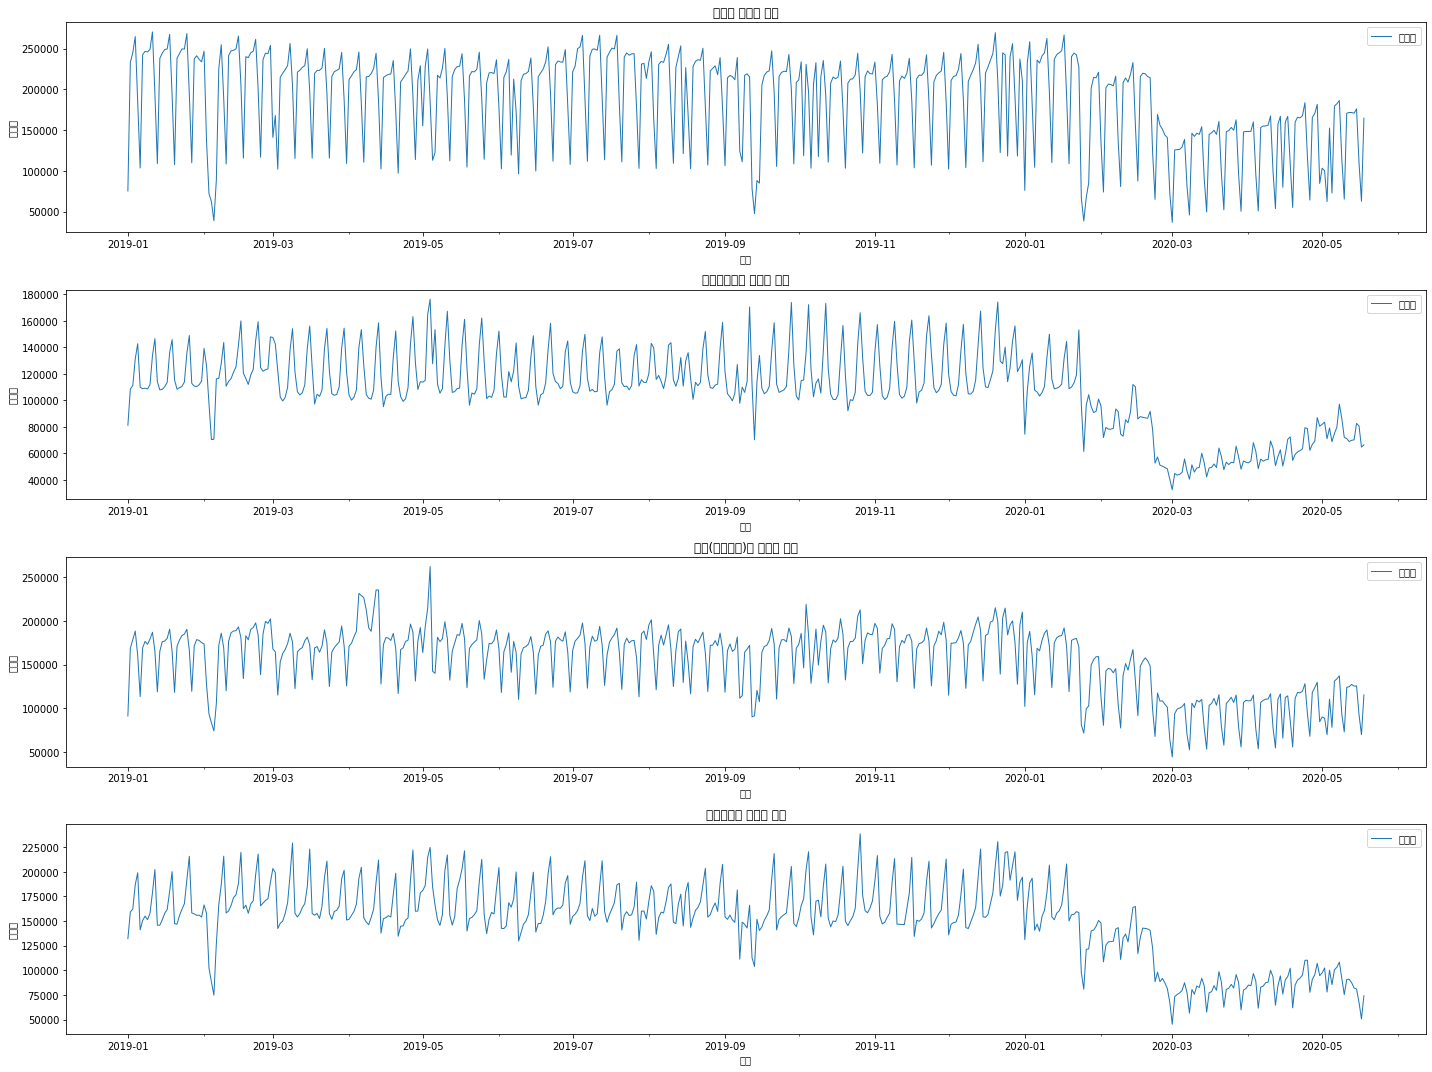

In [ ]:
fig, axes = plt.subplots(4,1,figsize=(20,15))
axes[0].plot(weather_add_covid.loc[0:503,['일시']], weather_add_covid.loc[0:503,['승하차인원']], label='승하차', lw=1)
axes[0].set_xlabel('일시')
axes[0].set_ylabel('승하차')
axes[0].set_title('강남역 승하차 인원')
axes[0].xaxis.set_minor_locator(md.MonthLocator())
axes[0].legend()
axes[1].plot(weather_add_covid.loc[504:1007,['일시']], weather_add_covid.loc[504:1007,['승하차인원']], label='승하차', lw=1)
axes[1].set_xlabel('일시')
axes[1].set_ylabel('승하차')
axes[1].set_title('고속터미널역 승하차 인원')
axes[1].xaxis.set_minor_locator(md.MonthLocator())
axes[1].legend()
axes[2].plot(weather_add_covid.loc[1008:1511,['일시']], weather_add_covid.loc[1008:1511,['승하차인원']], label='승하차', lw=1)
axes[2].set_xlabel('일시')
axes[2].set_ylabel('승하차')
axes[2].set_title('잠실(송파구청)역 승하차 인원')
axes[2].xaxis.set_minor_locator(md.MonthLocator())
axes[2].legend()
axes[3].plot(weather_add_covid.loc[1512:2015,['일시']], weather_add_covid.loc[1512:2015,['승하차인원']], label='승하차', lw=1)
axes[3].set_xlabel('일시')
axes[3].set_ylabel('승하차')
axes[3].set_title('홍대입구역 승하차 인원')
axes[3].xaxis.set_minor_locator(md.MonthLocator())
axes[3].legend()
plt.tight_layout()
plt.savefig('metro_3.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_

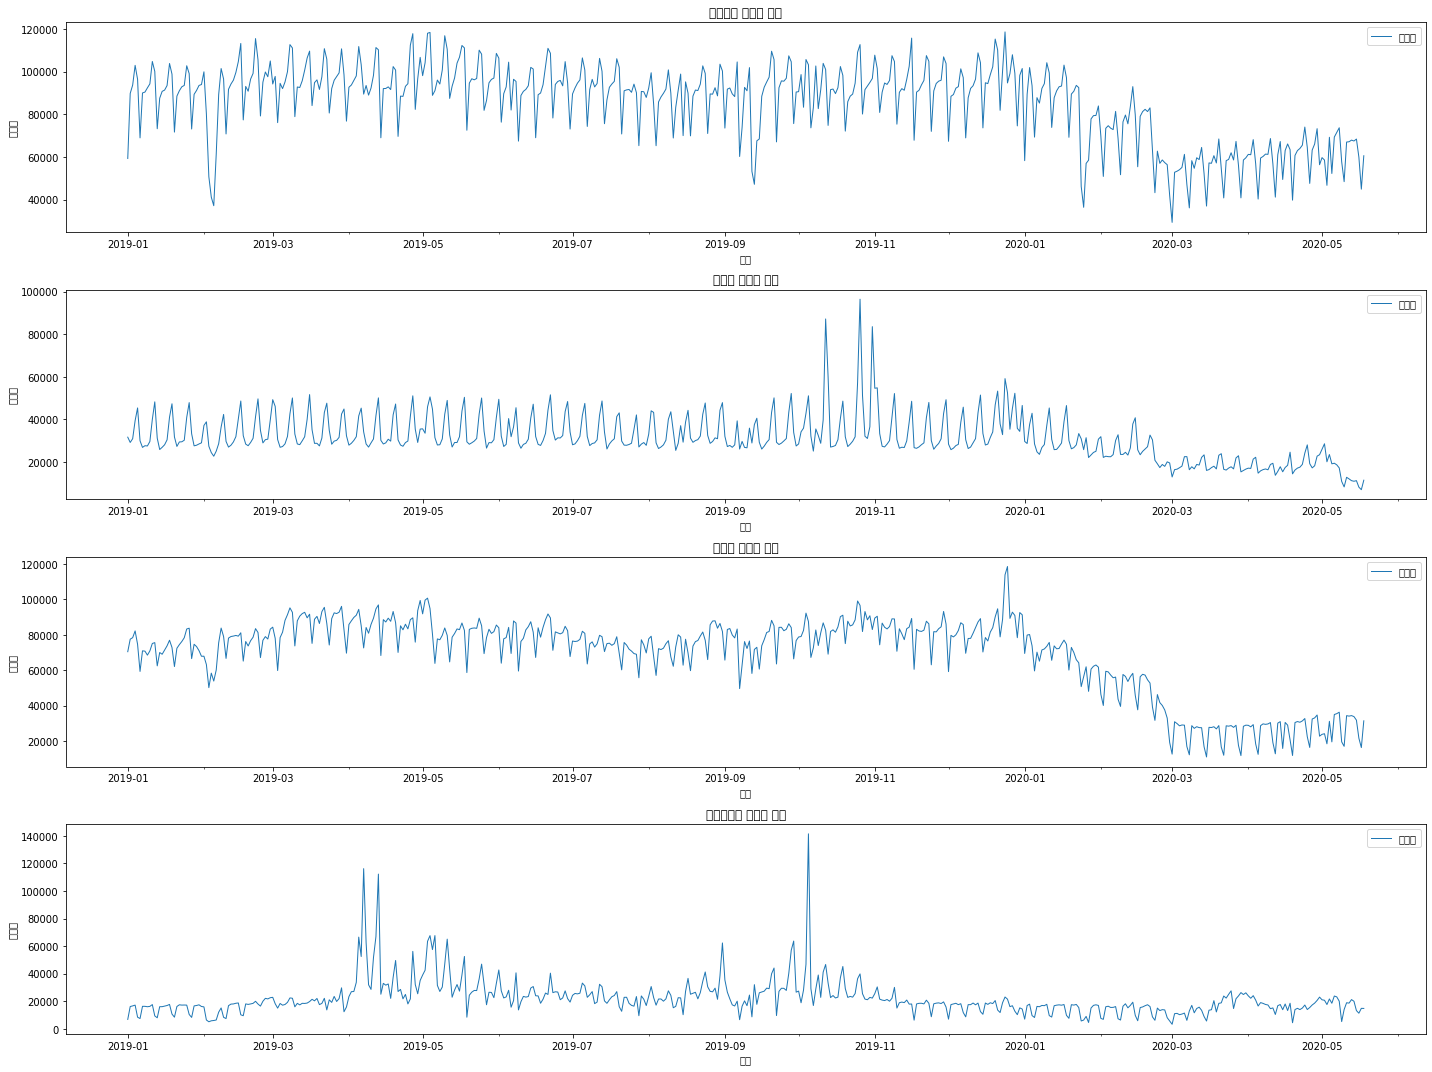

In [ ]:
fig, axes = plt.subplots(4,1,figsize=(20,15))
axes[0].plot(weather_add_covid.loc[2016:2519,['일시']], weather_add_covid.loc[2016:2519,['승하차인원']], label='승하차', lw=1)
axes[0].set_xlabel('일시')
axes[0].set_ylabel('승하차')
axes[0].set_title('건대입구 승하차 인원')
axes[0].xaxis.set_minor_locator(md.MonthLocator())
axes[0].legend()
axes[1].plot(weather_add_covid.loc[2520:3023,['일시']], weather_add_covid.loc[2520:3023,['승하차인원']], label='승하차', lw=1)
axes[1].set_xlabel('일시')
axes[1].set_ylabel('승하차')
axes[1].set_title('이태원 승하차 인원')
axes[1].xaxis.set_minor_locator(md.MonthLocator())
axes[1].legend()
axes[2].plot(weather_add_covid.loc[3024:3527,['일시']], weather_add_covid.loc[3024:3527,['승하차인원']], label='승하차', lw=1)
axes[2].set_xlabel('일시')
axes[2].set_ylabel('승하차')
axes[2].set_title('명동역 승하차 인원')
axes[2].xaxis.set_minor_locator(md.MonthLocator())
axes[2].legend()
axes[3].plot(weather_add_covid.loc[3528:4031,['일시']], weather_add_covid.loc[3528:4031,['승하차인원']], label='승하차', lw=1)
axes[3].set_xlabel('일시')
axes[3].set_ylabel('승하차')
axes[3].set_title('여의나루역 승하차 인원')
axes[3].xaxis.set_minor_locator(md.MonthLocator())
axes[3].legend()
plt.tight_layout()
plt.show()

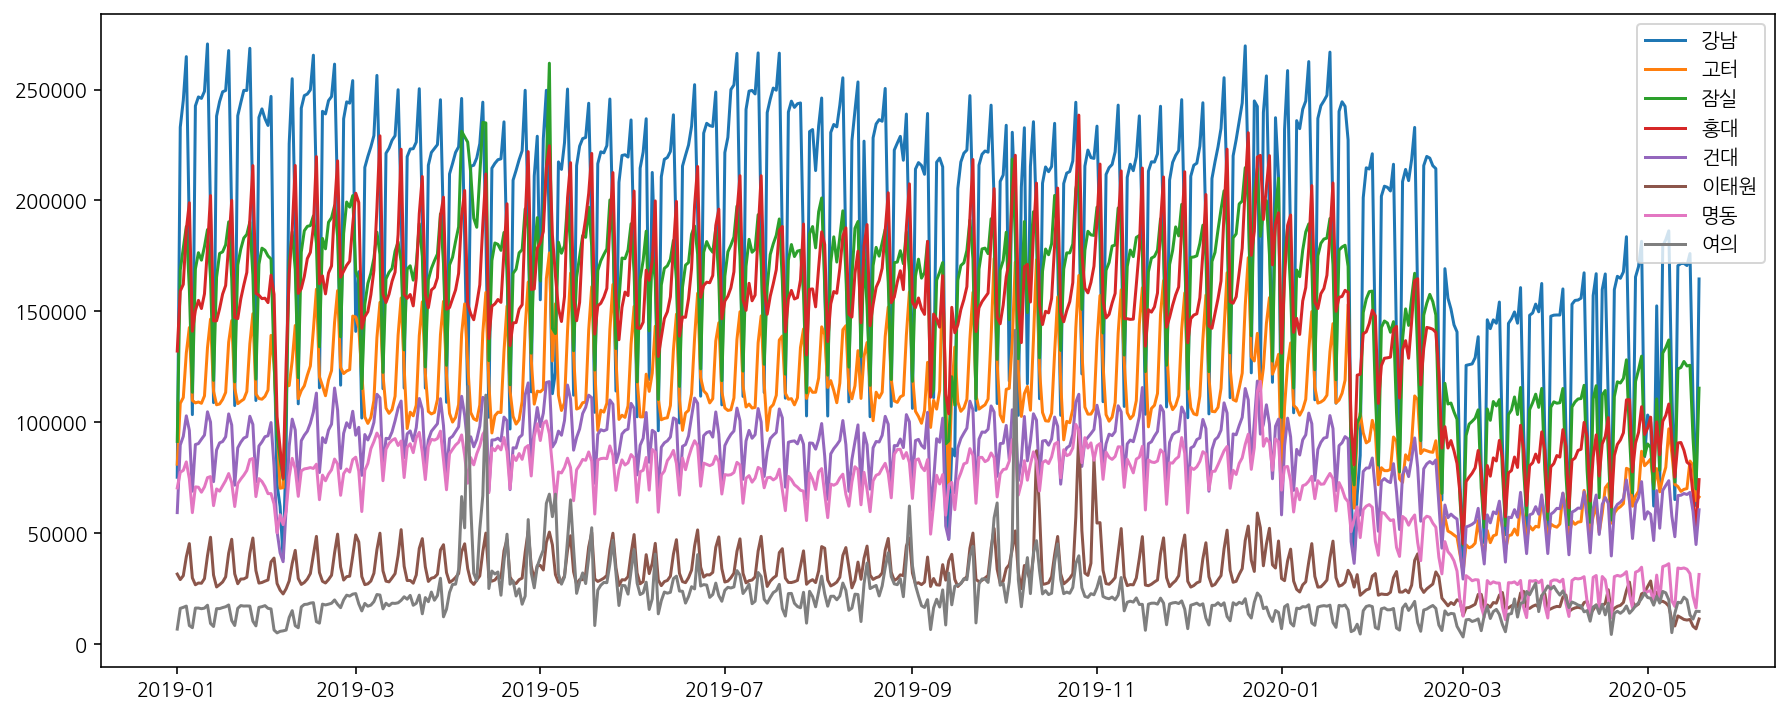

In [ ]:
plt.figure(figsize=(15, 6))
for i in weather_add_covid.역명.unique():
  subway = ['강남','고터','잠실','홍대','건대','이태원','명동','여의']
  plt.plot(weather_add_covid[weather_add_covid.역명 == i].일시, weather_add_covid[weather_add_covid.역명 == i].승하차인원, label=subway[i-1])
plt.legend()

In [ ]:
def corr_graph(data_frame, subway_num, idx_col, y_cols):
    df_set = data_frame[data_frame.역명 == subway_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.iloc[:,0], df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.iloc[:,0], df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

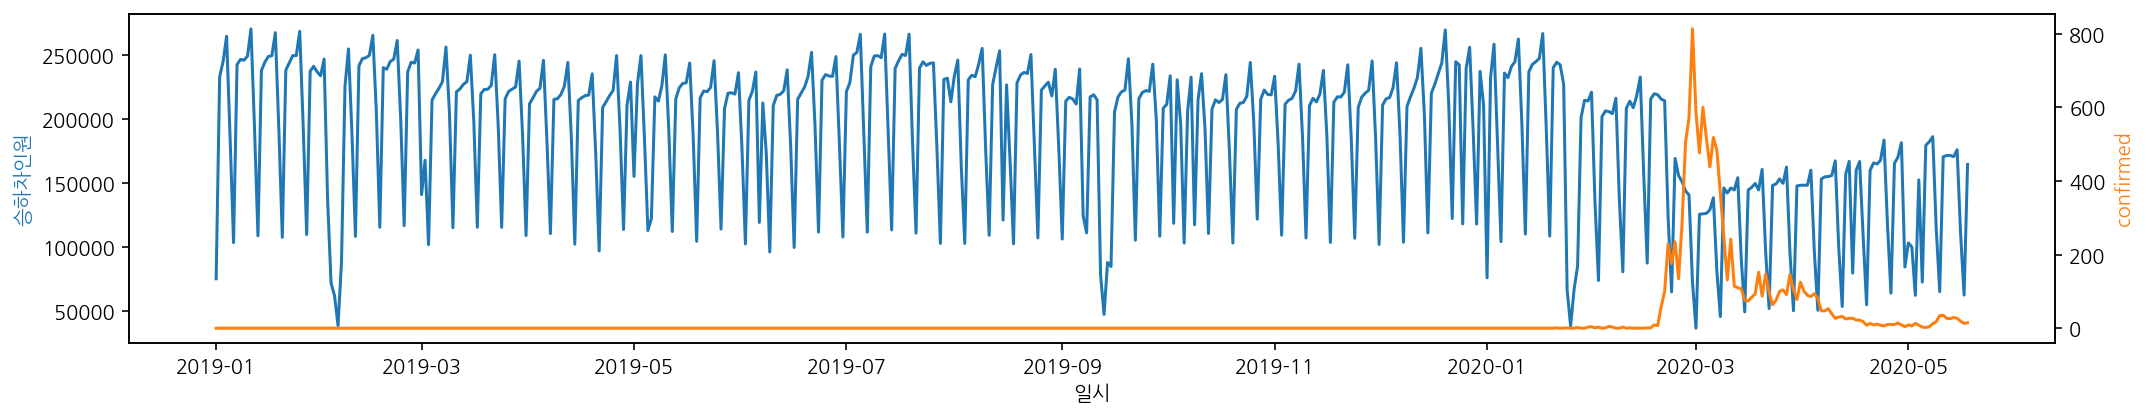

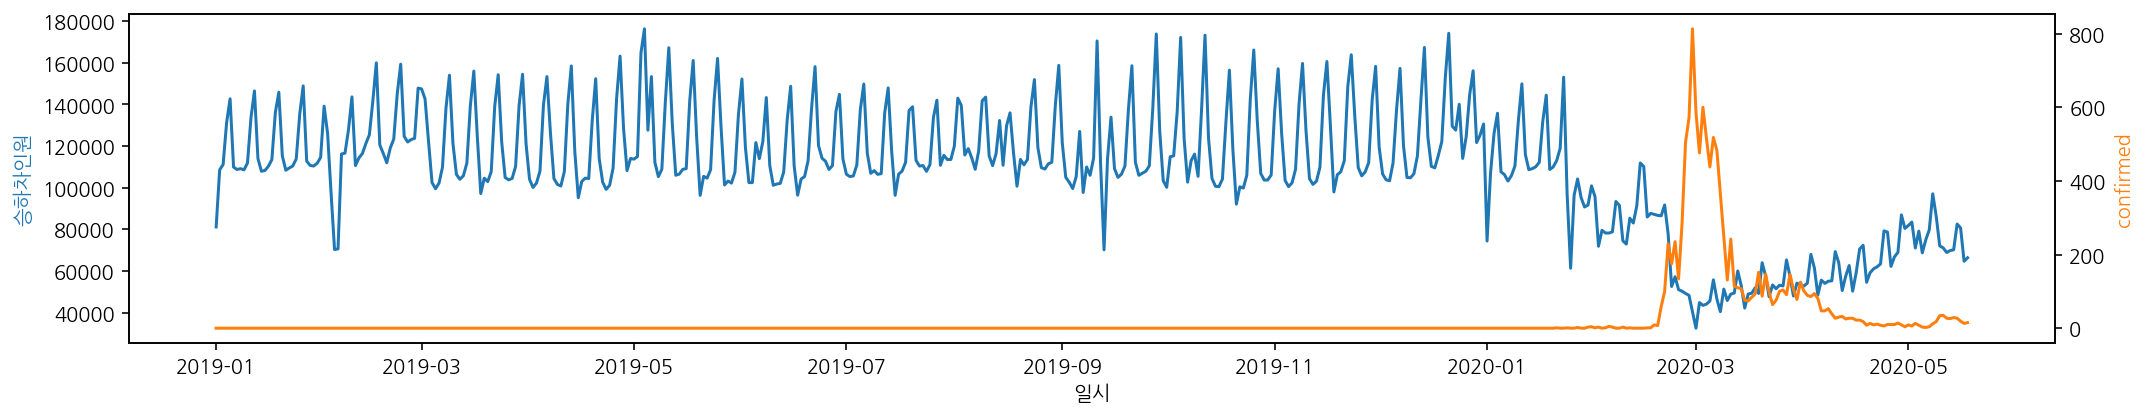

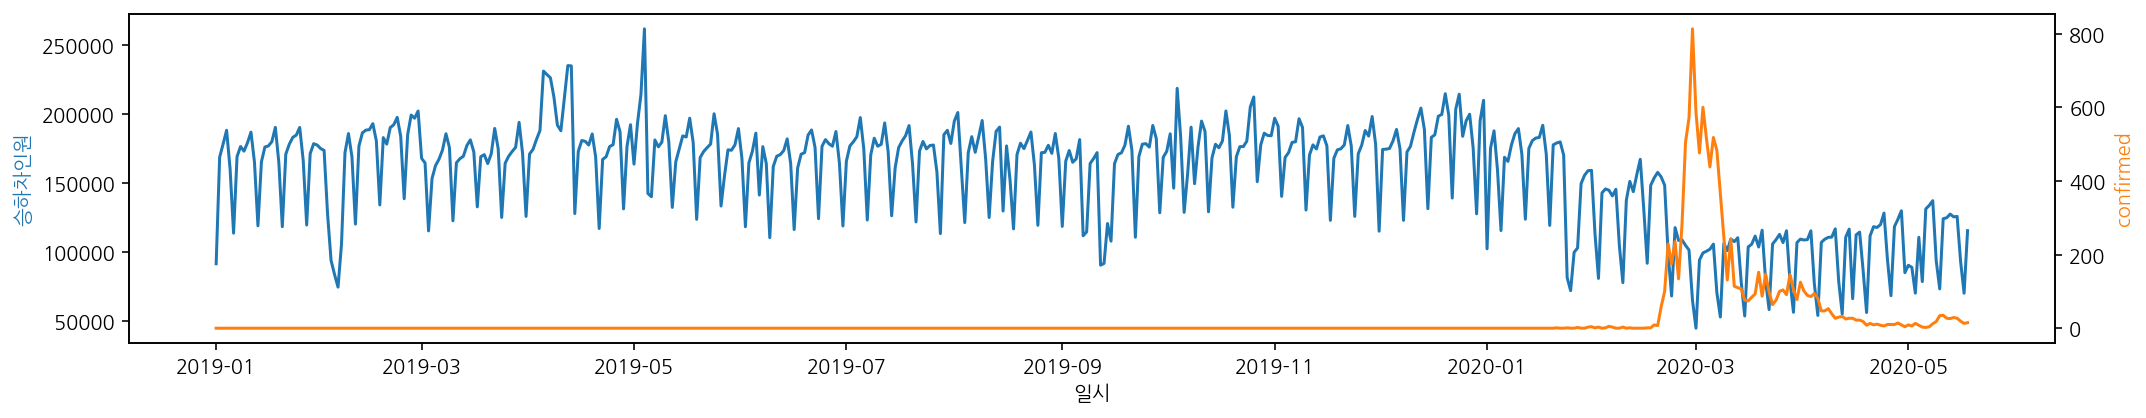

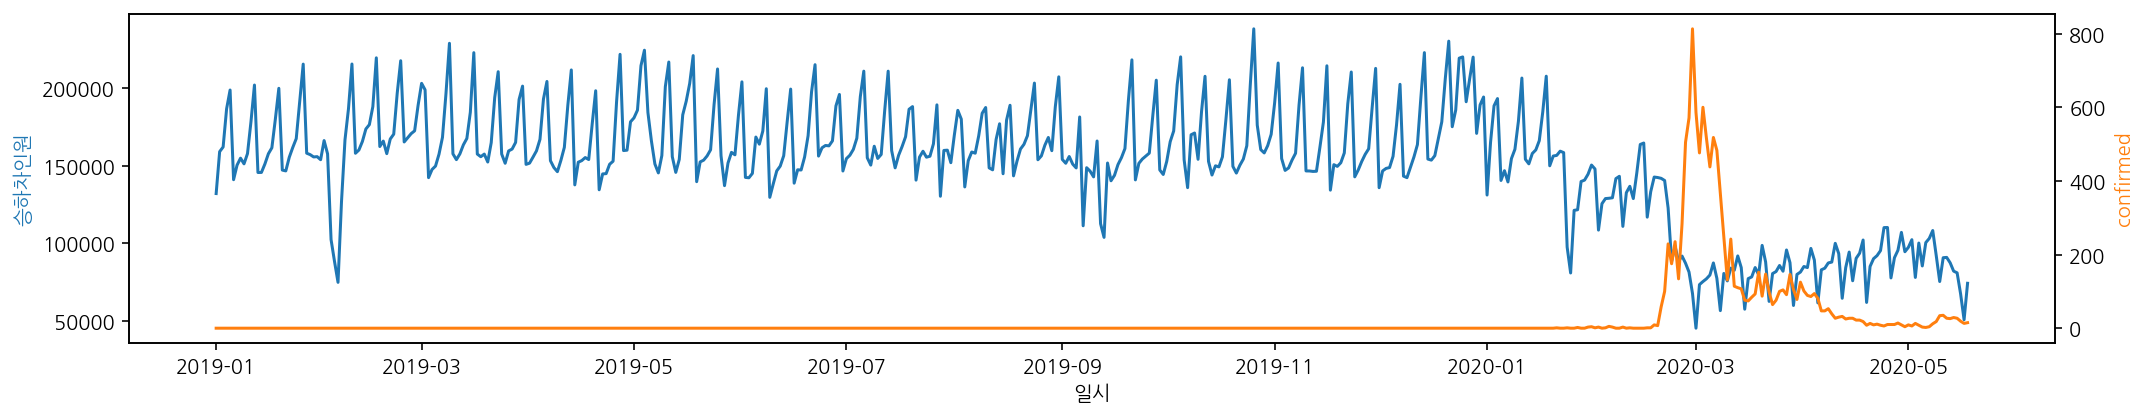

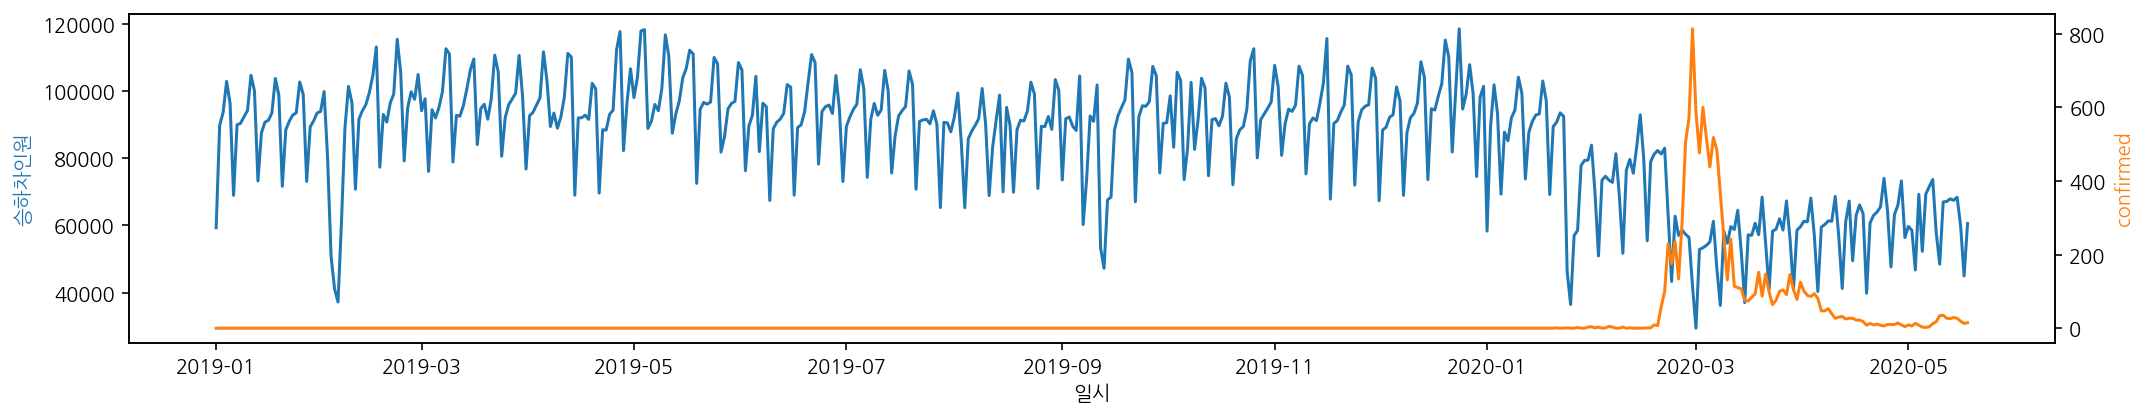

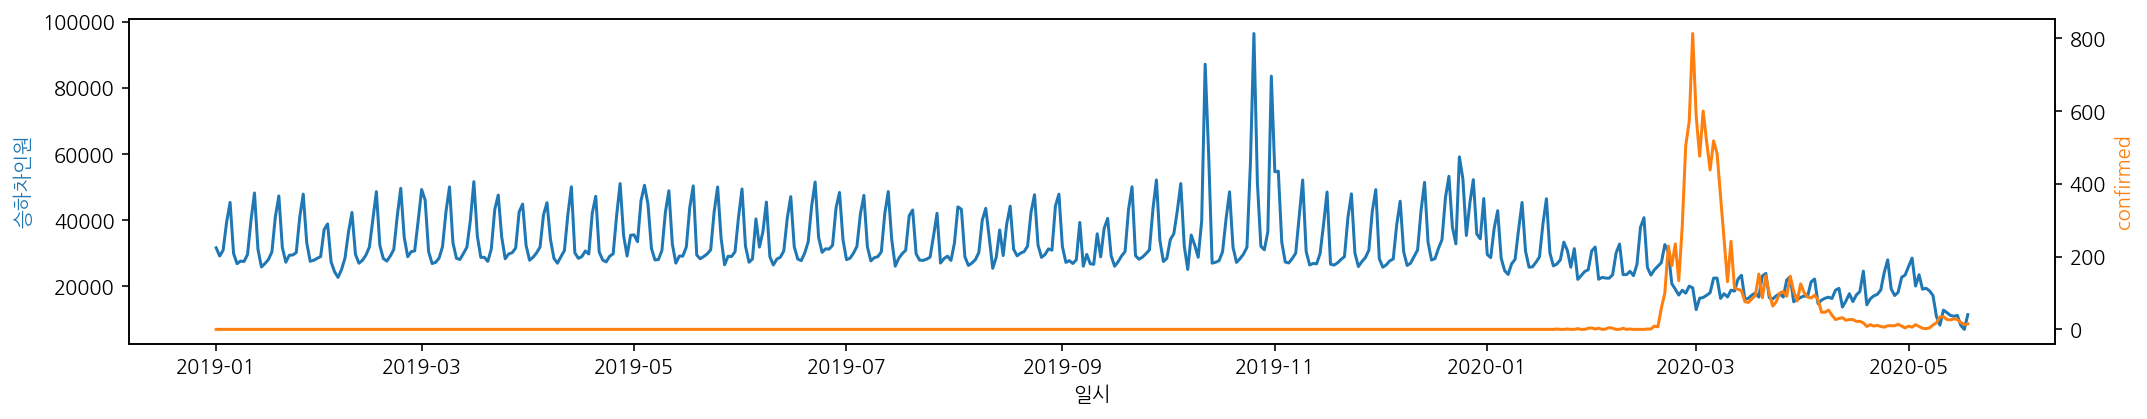

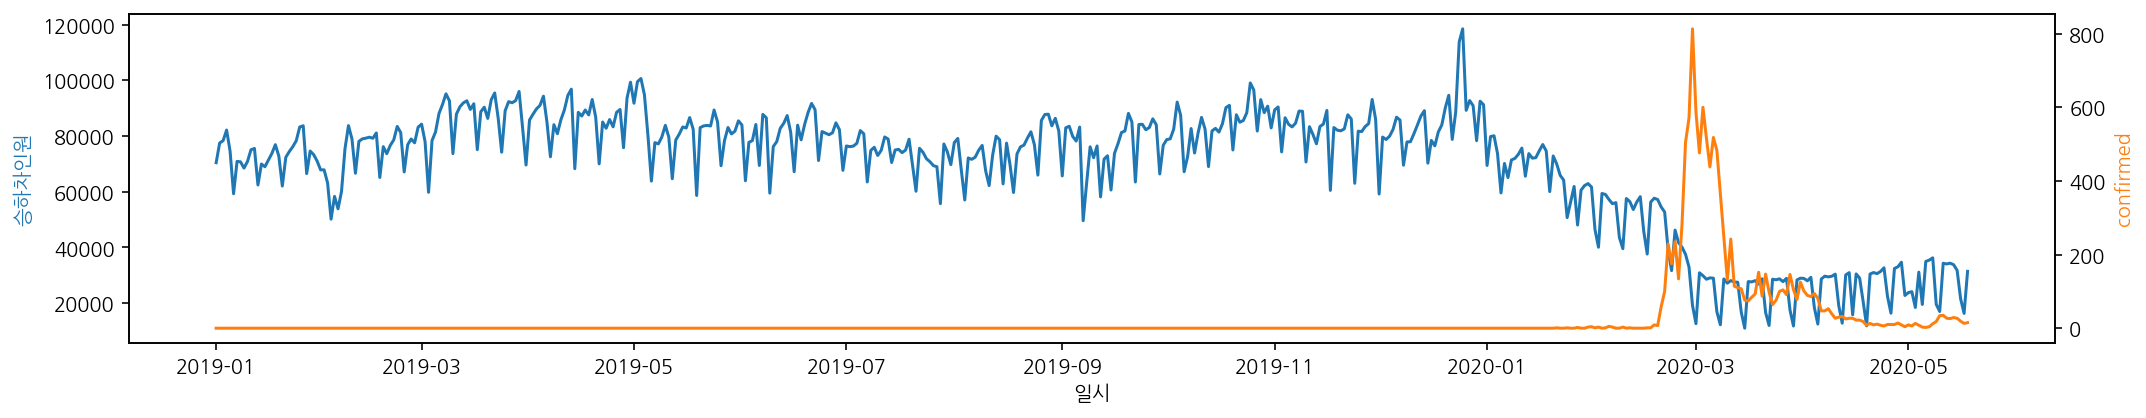

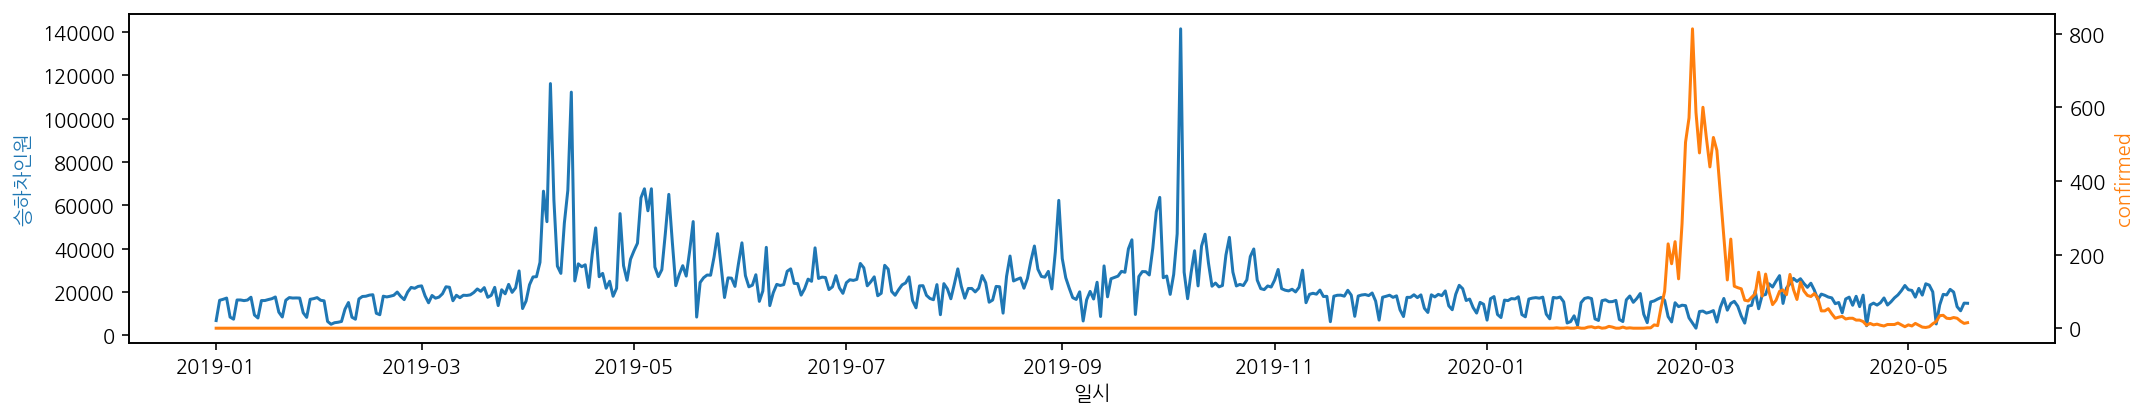

In [ ]:
for i in weather_add_covid.역명.unique():
    corr_graph(weather_add_covid, i, '일시', ['승하차인원', 'confirmed'])


In [ ]:
#승하차인원 정규화
import numpy as np
weather_add_covid_norm = weather_add_covid.copy()

normalized_arr = np.array([])
for i in weather_add_covid_norm.역명.unique():
    df_set = weather_add_covid_norm[weather_add_covid_norm.역명 == i].승하차인원.values
    set_arr = np.array([(float(i) / float(df_set[0]))-1 for i in df_set])
    normalized_arr = np.concatenate((normalized_arr, set_arr))

weather_add_covid_norm.insert(9, 'normalize', normalized_arr)

In [ ]:
weather_add_covid_norm

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed,normalize
0,2019-01-01,-3.7,0.0,1.8,2호선,1,75273,1,0.0,0.000000
1,2019-01-02,-3.5,0.0,1.5,2호선,1,233032,0,0.0,2.095825
2,2019-01-03,-1.9,0.0,1.1,2호선,1,245143,0,0.0,2.256719
3,2019-01-04,-0.5,0.0,1.3,2호선,1,264826,1,0.0,2.518207
4,2019-01-05,-1.5,0.0,2.0,2호선,1,185844,1,0.0,1.468933
...,...,...,...,...,...,...,...,...,...,...
4027,2020-05-14,20.9,0.0,0.4,5호선,8,19958,0,29.0,1.931551
4028,2020-05-15,16.9,9.0,0.8,5호선,8,13201,1,27.0,0.939042
4029,2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19.0,0.661575
4030,2020-05-17,19.2,0.0,0.7,5호선,8,14847,1,13.0,1.180817


In [ ]:
weather_add_corr = weather_add_covid.set_index('일시')
weather_add_corr

,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed
일시,,,,,,,,
2019-01-01,-3.7,0.0,1.8,2호선,1,75273,1,0.0
2019-01-02,-3.5,0.0,1.5,2호선,1,233032,0,0.0
2019-01-03,-1.9,0.0,1.1,2호선,1,245143,0,0.0
2019-01-04,-0.5,0.0,1.3,2호선,1,264826,1,0.0
2019-01-05,-1.5,0.0,2.0,2호선,1,185844,1,0.0
...,...,...,...,...,...,...,...,...
2020-05-14,20.9,0.0,0.4,5호선,8,19958,0,29.0
2020-05-15,16.9,9.0,0.8,5호선,8,13201,1,27.0
2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19.0


In [ ]:
#코로나 확진자와 승하차인원 -0.17, 역명과 승하차인원 -0.75
weather_add_corr.corr()

,평균기온(°C),일강수량(mm),평균 풍속(m/s),역명,승하차인원,휴일여부,confirmed
평균기온(°C),1.000000,0.184891,-0.123823,-1.490512e-02,0.046130,0.000236,-1.365748e-01
일강수량(mm),0.184891,1.000000,0.001004,-1.842441e-02,0.005778,-0.038677,-4.669387e-02
평균 풍속(m/s),-0.123823,0.001004,1.000000,-3.158901e-02,0.083108,-0.036253,3.481998e-02
역명,-0.014905,-0.018424,-0.031589,1.000000e+00,-0.756888,0.000000,-1.707052e-19
승하차인원,0.046130,0.005778,0.083108,-7.568876e-01,1.000000,-0.038144,-1.758779e-01
휴일여부,0.000236,-0.038677,-0.036253,0.000000e+00,-0.038144,1.000000,1.374147e-02
confirmed,-0.136575,-0.046694,0.034820,-1.707052e-19,-0.175878,0.013741,1.000000e+00


In [ ]:
weather_add_covid_corr = weather_add_covid.set_index('일시')

In [ ]:
weather_add_covid_corr.drop(['구','노선명'],axis=1,inplace=True)

In [ ]:
weather_add_covid_corr

,평균기온(°C),일강수량(mm),평균 풍속(m/s),승하차인원,휴일여부,confirmed
일시,,,,,,
2019-01-01,-3.7,0.0,1.8,75273,1,0.0
2019-01-02,-3.5,0.0,1.5,233032,0,0.0
2019-01-03,-1.9,0.0,1.1,245143,0,0.0
2019-01-04,-0.5,0.0,1.3,264826,1,0.0
2019-01-05,-1.5,0.0,2.0,185844,1,0.0
...,...,...,...,...,...,...
2020-05-14,20.9,0.0,0.4,19958,0,29.0
2020-05-15,16.9,9.0,0.8,13201,1,27.0
2020-05-16,17.0,1.5,0.6,11312,1,19.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
weather_add_covid_corr[:]=scaler.fit_transform(weather_add_covid_corr[:])
weather_add_covid_corr.head(15)

,평균기온(°C),일강수량(mm),평균 풍속(m/s),승하차인원,휴일여부,confirmed
일시,,,,,,
2019-01-01,0.136792,0.0,0.229730,0.269378,1.0,0.0
2019-01-02,0.141509,0.0,0.189189,0.859619,0.0,0.0
2019-01-03,0.179245,0.0,0.135135,0.904931,0.0,0.0
2019-01-04,0.212264,0.0,0.162162,0.978573,1.0,0.0
2019-01-05,0.188679,0.0,0.256757,0.683069,1.0,0.0
2019-01-06,0.186321,0.0,0.162162,0.374919,0.0,0.0
2019-01-07,0.207547,0.0,0.175676,0.895487,0.0,0.0
2019-01-08,0.169811,0.0,0.256757,0.910599,0.0,0.0
2019-01-09,0.139151,0.0,0.162162,0.908220,0.0,0.0


In [ ]:
#정규화시켜도 상관관계는 정규화안시킨것과 비슷하게 나옴
#승하차와 확진자 -0.17, 승하차 휴일 0.07
weather_add_covid_corr.corr()

,평균기온(°C),일강수량(mm),평균 풍속(m/s),승하차인원,휴일여부,confirmed
평균기온(°C),1.000000,0.184891,-0.123823,0.046130,-0.006898,-0.136575
일강수량(mm),0.184891,1.000000,0.001004,0.005778,-0.035509,-0.046694
평균 풍속(m/s),-0.123823,0.001004,1.000000,0.083108,-0.024346,0.034820
승하차인원,0.046130,0.005778,0.083108,1.000000,0.073744,-0.175878
휴일여부,-0.006898,-0.035509,-0.024346,0.073744,1.000000,0.013469
confirmed,-0.136575,-0.046694,0.034820,-0.175878,0.013469,1.000000


In [ ]:
import math

In [ ]:
weather_add_covid_corr_log = weather_add_covid_corr.apply(lambda x: np.log(x+1))

In [ ]:
#기존 상관관계와 로그변환을 해도 거의 비슷하게 나옴
#평균풍속이 상관관계가 0.1로 증가함
weather_add_covid_corr_log.corr()

,평균기온(°C),일강수량(mm),평균 풍속(m/s),승하차인원,휴일여부,confirmed
평균기온(°C),1.000000,0.186004,-0.126857,0.043443,-0.008979,-0.128561
일강수량(mm),0.186004,1.000000,0.003656,0.002547,-0.040275,-0.050046
평균 풍속(m/s),-0.126857,0.003656,1.000000,0.107390,-0.026449,0.045921
승하차인원,0.043443,0.002547,0.107390,1.000000,0.071487,-0.189862
휴일여부,-0.008979,-0.040275,-0.026449,0.071487,1.000000,0.008443
confirmed,-0.128561,-0.050046,0.045921,-0.189862,0.008443,1.000000


In [ ]:
weather_add_corr_1=weather_add_covid[weather_add_covid['역명']>1]
weather_add_corr_1

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed
504,2019-01-01,-4.2,0.0,1.5,3호선,2,81143,0,0.0
505,2019-01-02,-4.2,0.0,1.5,3호선,2,108547,0,0.0
506,2019-01-03,-3.1,0.0,1.0,3호선,2,111173,0,0.0
507,2019-01-04,-0.8,0.0,1.1,3호선,2,131287,1,0.0
508,2019-01-05,-2.0,0.0,1.9,3호선,2,142740,1,0.0
...,...,...,...,...,...,...,...,...,...
4027,2020-05-14,20.9,0.0,0.4,5호선,8,19958,0,29.0
4028,2020-05-15,16.9,9.0,0.8,5호선,8,13201,1,27.0
4029,2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19.0
4030,2020-05-17,19.2,0.0,0.7,5호선,8,14847,0,13.0


In [ ]:
weather_add_corr_1.set_index('일시', inplace=True)
weather_add_corr_1.drop(['노선명','역명'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
weather_add_corr_1.corr()

,평균기온(°C),일강수량(mm),평균 풍속(m/s),승하차인원,휴일여부,confirmed
평균기온(°C),1.000000,0.184554,-0.117494,0.051933,0.007898,-0.136982
일강수량(mm),0.184554,1.000000,0.013546,-0.008586,-0.042206,-0.046790
평균 풍속(m/s),-0.117494,0.013546,1.000000,0.193480,-0.028350,0.034080
승하차인원,0.051933,-0.008586,0.193480,1.000000,0.124806,-0.188549
휴일여부,0.007898,-0.042206,-0.028350,0.124806,1.000000,0.032352
confirmed,-0.136982,-0.046790,0.034080,-0.188549,0.032352,1.000000


In [ ]:
import numpy as np

In [ ]:
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7)

In [ ]:
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [ ]:
# 하이퍼파라미터
tf.set_random_seed(777)
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
 
seq_length = 7            # 1개 시퀀스의 길이(시계열데이터 입력 개수) 일주일 단위
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0           # dropout할 때 keep할 비율
 
epoch_num = 200          # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

In [ ]:
weather_add_covid_1 = weather_add_covid.set_index('일시')
del weather_add_covid_1['노선명']
train_info = weather_add_covid_1[weather_add_covid_1.역명 == 2]
train_info = train_info.drop('역명',axis=1)
train_info = train_info.values[0:].astype(np.float) # 변수들 문자열을 부동소수점형으로 변환한다

In [ ]:
temp = train_info[:,0:1]
norm_temp = min_max_scaling(temp) # 평균기온 데이터 정규화 처리
rain = train_info[:,1:2]
norm_rain = min_max_scaling(rain) # 강수량 데이터 정규화 처리
wind = train_info[:,2:3]
norm_wind = min_max_scaling(wind) # 평균풍속 데이터 정규화 처리
people = train_info[:,3:4]
norm_people = min_max_scaling(people) # 승하차인원 데이터 정규화 처리
holi = train_info[:,4:5]
norm_holi = min_max_scaling(holi) # 휴일여부 데이터 정규화 처리
corona = train_info[:,5:6]
norm_corona = min_max_scaling(corona) # 평균기온 데이터 정규화 처리

In [ ]:
x = np.concatenate((norm_temp, norm_rain,norm_wind,norm_holi,norm_corona,norm_people), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용
 
y = x[:, [-1]] # 타켓은 주식 종가이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

x.shape:  (504, 6)
x[0]:  [0.08184143 0.         0.27999999 0.         0.         0.33816835]
x[-1]:  [0.68542199 0.22439024 0.39999998 0.         0.01845018 0.23530557]
y[0]:  [0.33816835]
y[-1]:  [0.23530557]


In [ ]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용
 
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

[[0.08184143 0.         0.27999999 0.         0.         0.33816835]
 [0.08184143 0.         0.27999999 0.         0.         0.5286313 ]
 [0.10997442 0.         0.08       0.         0.         0.54688249]
 [0.16879795 0.         0.12       0.9999999  0.         0.68667857]
 [0.13810742 0.         0.43999998 0.9999999  0.         0.76627908]
 [0.12531969 0.         0.12       0.         0.         0.537882  ]
 [0.14322251 0.         0.19999999 0.         0.         0.53016034]] -> [0.53294737]


In [ ]:
# 학습용/테스트용 데이터 생성
# 전체 80%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.8)
# 나머지(20%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])
 
 
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)
 
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 7, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [ ]:
#pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 49kB/s 
     |████████████████████████████████| 3.2MB 29.2MB/s 
     |████████████████████████████████| 491kB 29.5MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [ ]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
 
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [ ]:
#tf.reset_default_graph()

In [ ]:
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 7, 20), dtype=float32)


In [ ]:
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

In [ ]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임
 
train = optimizer.minimize(loss)

In [ ]:
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))
 
 
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
import datetime
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...
epoch: 100, train_error(A): 0.11402057856321335, test_error(B): 0.2305496782064438, B-A: 0.11652909964323044
epoch: 200, train_error(A): 0.0814238041639328, test_error(B): 0.2772062420845032, B-A: 0.19578243792057037
elapsed_time: 0:00:01.269711
elapsed_time per epoch: 0:00:00.006349


In [ ]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

input_data_column_cnt: 6,output_data_column_cnt: 1,seq_length: 7,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 200,learning_rate: 0.01,train_error: 0.081423804,test_error: 0.27720624,min_test_error: 0.23054968


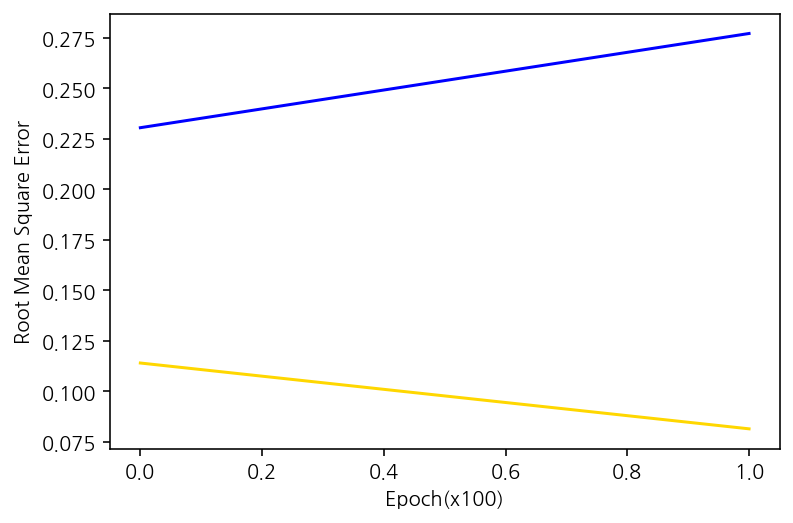

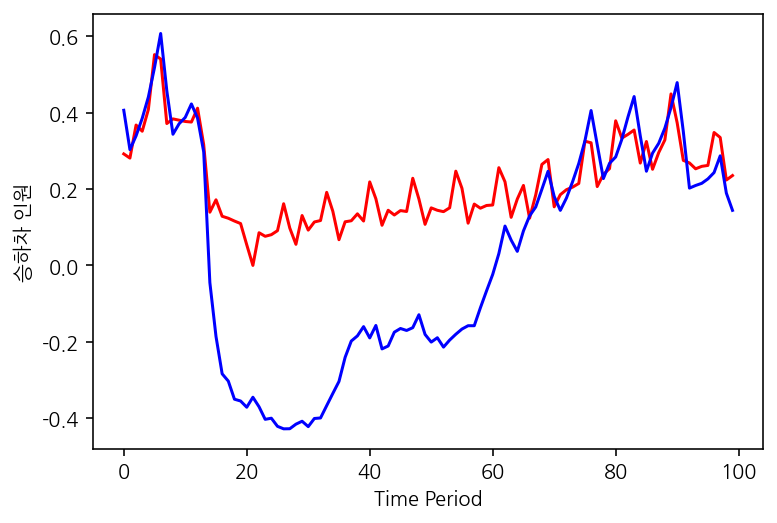

In [ ]:
# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')
 
plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('승하차 인원')
plt.show()

In [ ]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 승하차인원을 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(people,test_predict) # 승하차인원데이터를 역정규화한다
print("Tomorrow's train people", test_predict[0]) # 예측한 승하차인원을 출력한다

recent_data.shape: (1, 7, 6)
recent_data: [[[0.57033248 0.0097561  0.39999998 0.         0.03321033 0.25290344]
  [0.60102302 0.         0.31999999 0.         0.03198032 0.25933932]
  [0.69309463 0.         0.15999999 0.         0.03567036 0.26175798]
  [0.59846547 0.09756098 0.35999999 0.9999999  0.03321033 0.34797506]
  [0.63171355 0.0097561  0.         0.9999999  0.02337023 0.33493651]
  [0.70076726 0.         0.15999999 0.         0.01599016 0.22353195]
  [0.68542199 0.22439024 0.39999998 0.         0.01845018 0.23530557]]]
test_predict [0.2134136]
Tomorrow's train people [63193.164]


In [ ]:
import numpy as np
from scipy import stats
weather_metro_corona = pd.read_csv('wether_metro_covid_1.csv',encoding='CP949')
weather_metro_corona

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed
0,20190101,-3.7,0.0,1.8,2호선,1,75273,1,0
1,20190102,-3.5,0.0,1.5,2호선,1,233032,0,0
2,20190103,-1.9,0.0,1.1,2호선,1,245143,0,0
3,20190104,-0.5,0.0,1.3,2호선,1,264826,1,0
4,20190105,-1.5,0.0,2.0,2호선,1,185844,1,0
...,...,...,...,...,...,...,...,...,...
4027,20200514,20.9,0.0,0.4,5호선,8,19958,0,29
4028,20200515,16.9,9.0,0.8,5호선,8,13201,1,27
4029,20200516,17.0,1.5,0.6,5호선,8,11312,1,19
4030,20200517,19.2,0.0,0.7,5호선,8,14847,1,13


In [ ]:
weather_metro_corona_1 = weather_metro_corona.groupby('일시')[['승하차인원']].mean()
weather_metro_corona_1

,승하차인원
일시,
20190101,68514.125
20190102,110251.250
20190103,114547.250
20190104,126606.000
20190105,114071.750
...,...
20200514,72553.500
20200515,73730.125
20200516,56527.000


In [ ]:
weather_metro_corona_1.reset_index(inplace=True)
weather_metro_corona_1

,일시,승하차인원
0,20190101,68514.125
1,20190102,110251.250
2,20190103,114547.250
3,20190104,126606.000
4,20190105,114071.750
...,...,...
499,20200514,72553.500
500,20200515,73730.125
501,20200516,56527.000
502,20200517,41353.750


In [ ]:
#모든역 일자별 평균 등분산 검정
corona = df[df.일시 > 20200507] #이태원사태 이후
no_corona = df[df.일시 <= 20200507] #이태원사태 이전
lresult = stats.levene(corona.승하차인원, no_corona.승하차인원)
print('LeveneResult(F) : %.3f \np-value : %.3f \n' % (lresult))

LeveneResult(F) : 2.260 
p-value : 0.133 



In [ ]:
#모든역 일자별 평균 t-검정
corona = df[df.일시 > 20200507] #이태원사태 이후
no_corona = df[df.일시 <= 20200507] #이태원사태 이전
result = stats.ttest_ind(corona.승하차인원, no_corona.승하차인원, equal_var=True) 
print('\nt statistic : %.3f \np-value : %.3f \n' % (result))


t statistic : -5.014 
p-value : 0.000 



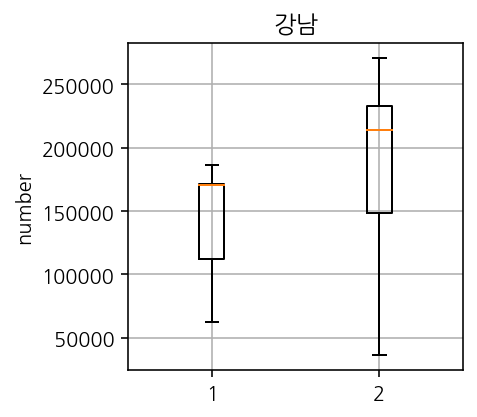

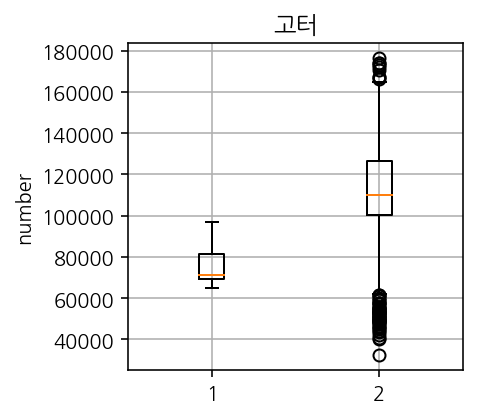

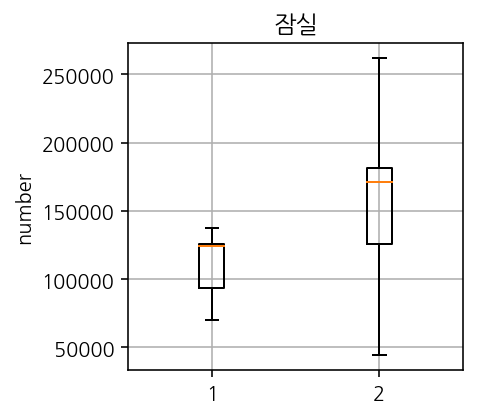

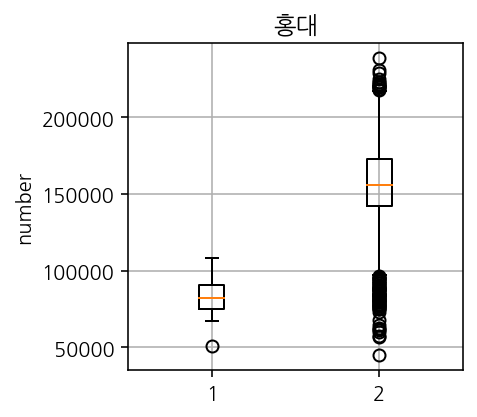

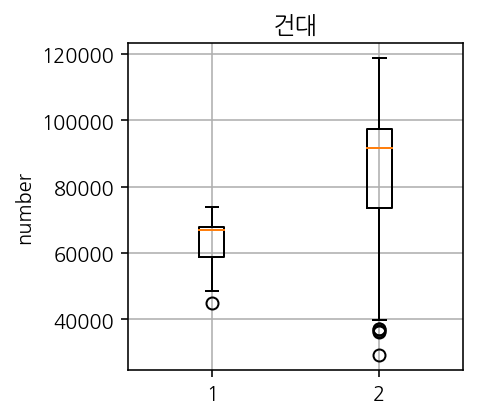

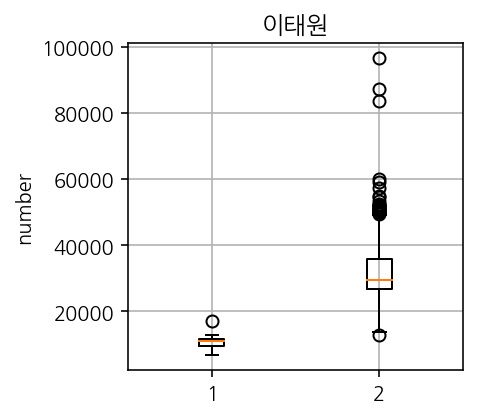

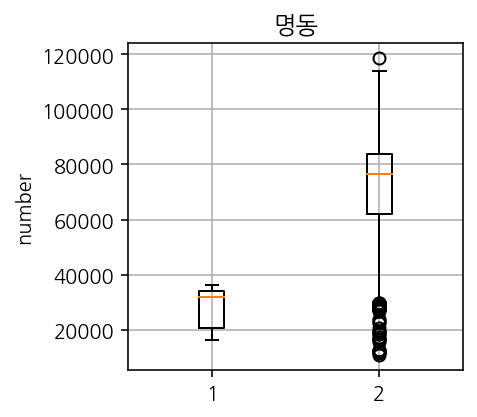

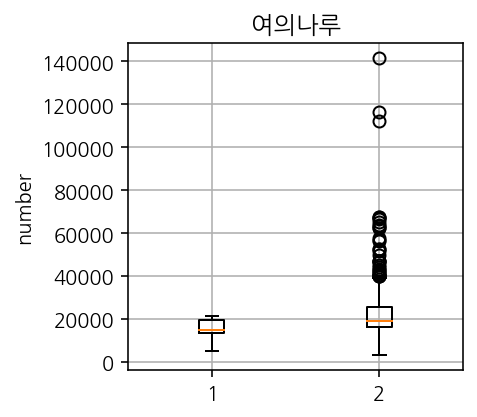

In [ ]:
from numpy import array
for i in weather_metro_corona.역명.unique():
  df = weather_metro_corona[weather_metro_corona.역명 == i]
  corona = df[df.일시 > 20200507] #이태원 클럽 사태 이후
  no_corona = df[df.일시 <= 20200507] #이태원 클럽 사태 이전
  corona_x1 = array(corona.승하차인원)
  no_corona_x2 = array(no_corona.승하차인원)
  plt.figure(figsize=(3, 3))
  plt.grid()
  plt.boxplot([corona_x1, no_corona_x2])
  plt.ylabel('number')
  subway = ['강남','고터','잠실','홍대','건대','이태원','명동','여의나루']
  plt.title(subway[i-1])
  plt.show()


In [ ]:
from scipy import stats
df = weather_metro_corona_1.copy()
corona = df[df.일시 > 20200219] #신천지사태 이후
no_corona = df[df.일시 <= 20200219] #신천지사태 이전
lresult = stats.levene(corona.승하차인원, no_corona.승하차인원)
print('LeveneResult(F) : %.3f \np-value : %.3f \n' % (lresult))

LeveneResult(F) : 2.925 
p-value : 0.088 



In [ ]:
corona = df[df.일시 > 20200219] #신천지사태 이후
no_corona = df[df.일시 <= 20200219] #신천지사태 이전
result = stats.ttest_ind(corona.승하차인원, no_corona.승하차인원, equal_var=True) 
print('\nt statistic : %.3f \np-value : %.3f \n' % (result))


t statistic : -24.753 
p-value : 0.000 



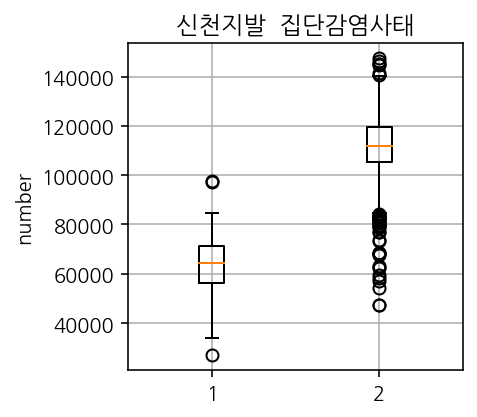

In [ ]:
df_1 = weather_metro_corona_1.copy()
corona_1 = df_1[df_1.일시 > 20200219] #신천지사태 이후
no_corona_1 = df_1[df_1.일시 <= 20200219] #신천지사태 이전
corona_x = array(corona_1.승하차인원)
no_corona_y = array(no_corona_1.승하차인원)
plt.figure(figsize=(3, 3))
plt.grid()
plt.boxplot([corona_x, no_corona_y])
plt.ylabel('number')
plt.title('신천지발  집단감염사태')
plt.show()

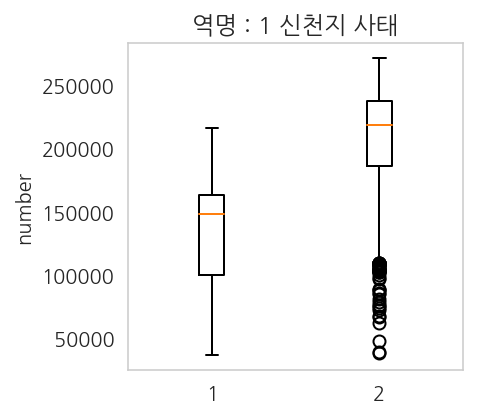

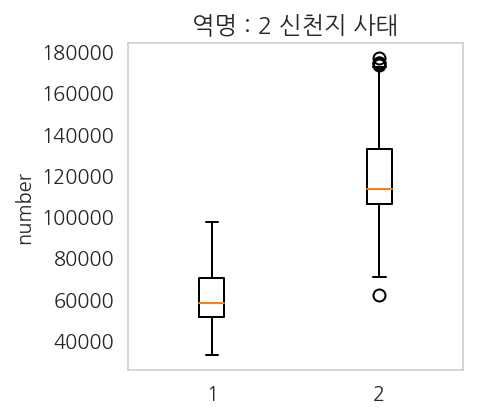

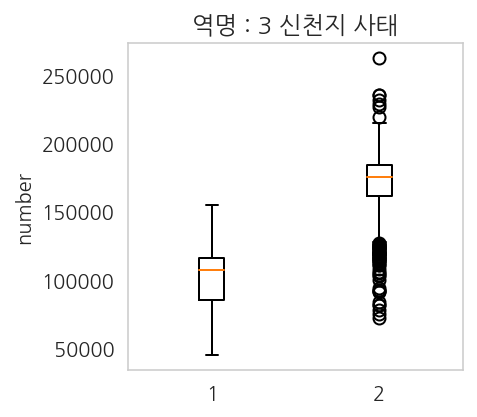

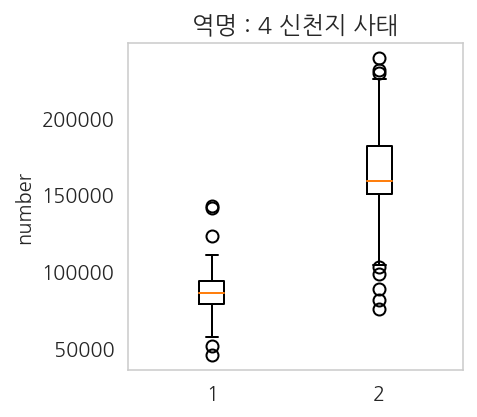

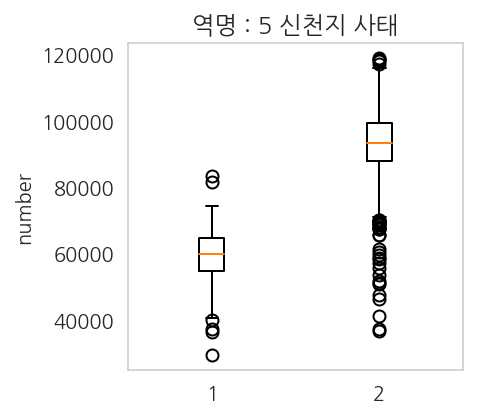

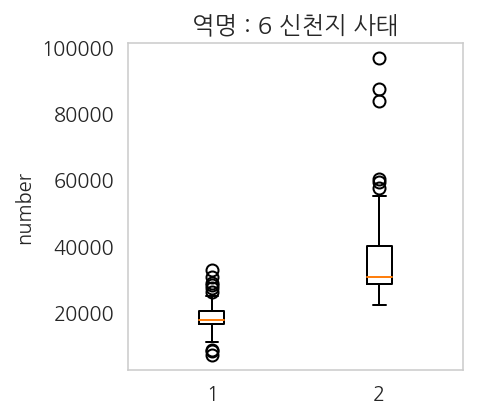

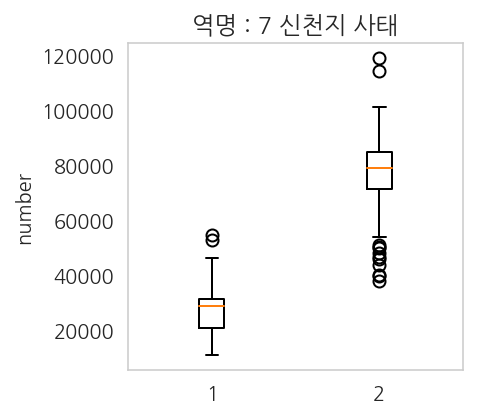

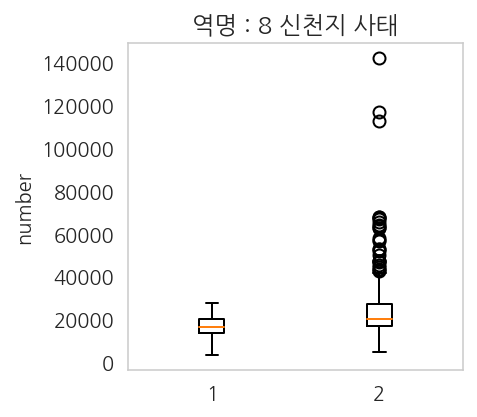

In [ ]:
for i in weather_metro_corona.역명.unique():
  df_1 = weather_metro_corona[weather_metro_corona.역명 == i]
  corona_1 = df_1[df_1.일시 > 20200219] #신천지사태 이후
  no_corona_1 = df_1[df_1.일시 <= 20200219] #신천지사태 이전
  corona_x = array(corona_1.승하차인원)
  no_corona_y = array(no_corona_1.승하차인원)
  plt.figure(figsize=(3, 3))
  plt.grid()
  plt.boxplot([corona_x, no_corona_y])
  plt.ylabel('number')
  plt.title('역명 : {} 신천지 사태'.format(i))
  plt.show()


In [ ]:
import numpy as np

In [ ]:
#Simple Moving Average
def make_sma_arr(window_num):
    ma_arr = np.array([])
    for i in weather_add_covid.역명.unique():
        df_set = weather_add_covid[weather_add_covid.역명 == i]
        ma_arr = np.concatenate((ma_arr, df_set.승하차인원.rolling(window=window_num).mean().values))
        
    return ma_arr

In [ ]:
sma_month = weather_add_covid.copy()

sma_month.insert(9, 'amount_2ma', make_sma_arr(2))
sma_month.insert(10, 'amount_3ma', make_sma_arr(3))
sma_month.insert(11, 'amount_7ma', make_sma_arr(7))
sma_month

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed,amount_2ma,amount_3ma,amount_7ma
0,2019-01-01,-3.7,0.0,1.8,2호선,1,75273,1,0.0,NaN,NaN,NaN
1,2019-01-02,-3.5,0.0,1.5,2호선,1,233032,0,0.0,154152.5,NaN,NaN
2,2019-01-03,-1.9,0.0,1.1,2호선,1,245143,0,0.0,239087.5,184482.666667,NaN
3,2019-01-04,-0.5,0.0,1.3,2호선,1,264826,1,0.0,254984.5,247667.000000,NaN
4,2019-01-05,-1.5,0.0,2.0,2호선,1,185844,1,0.0,225335.0,231937.666667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4027,2020-05-14,20.9,0.0,0.4,5호선,8,19958,0,29.0,20576.5,19929.666667,16847.428571
4028,2020-05-15,16.9,9.0,0.8,5호선,8,13201,1,27.0,16579.5,18118.000000,15871.285714
4029,2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19.0,12256.5,14823.666667,16740.714286
4030,2020-05-17,19.2,0.0,0.7,5호선,8,14847,1,13.0,13079.5,13120.000000,16863.285714


In [ ]:
sma_month.loc[4032]=['2020-05-19',0,0,0,'5호선',8,0,0,0,0,0,0]

In [ ]:
#rolling의 경우, window 3를 예를 들면 t 시점에 대한 값으로 t시점, t-1시점, t-2시점의 평균을 사용한다.
#우리가 필요한 것은 t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행
##즉 roling -> t시점 예측 (t-1+t-2+t-3)/3=t / window 3 -> t시점 예측 (t+t-1+t-2)/3=t
#이를 실행하기 위해 shift를 함
sma_month.amount_2ma=sma_month.amount_2ma.shift(1)
sma_month.amount_3ma=sma_month.amount_3ma.shift(1)
sma_month.amount_7ma=sma_month.amount_7ma.shift(1)
sma_month

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed,amount_2ma,amount_3ma,amount_7ma
0,2019-01-01 00:00:00,-3.7,0.0,1.8,2호선,1,75273,1,0.0,NaN,NaN,NaN
1,2019-01-02 00:00:00,-3.5,0.0,1.5,2호선,1,233032,0,0.0,NaN,NaN,NaN
2,2019-01-03 00:00:00,-1.9,0.0,1.1,2호선,1,245143,0,0.0,154152.5,NaN,NaN
3,2019-01-04 00:00:00,-0.5,0.0,1.3,2호선,1,264826,1,0.0,239087.5,184482.666667,NaN
4,2019-01-05 00:00:00,-1.5,0.0,2.0,2호선,1,185844,1,0.0,254984.5,247667.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4028,2020-05-15 00:00:00,16.9,9.0,0.8,5호선,8,13201,1,27.0,20576.5,19929.666667,16847.428571
4029,2020-05-16 00:00:00,17.0,1.5,0.6,5호선,8,11312,1,19.0,16579.5,18118.000000,15871.285714
4030,2020-05-17 00:00:00,19.2,0.0,0.7,5호선,8,14847,1,13.0,12256.5,14823.666667,16740.714286
4031,2020-05-18 00:00:00,19.7,26.5,1.0,5호선,8,14779,0,15.0,13079.5,13120.000000,16863.285714


In [ ]:
sma_month['일시'] = pd.to_datetime(sma_month['일시'], format='%Y-%m-%d')

In [ ]:
sma_month

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed,amount_2ma,amount_3ma,amount_7ma
0,2019-01-01,-3.7,0.0,1.8,2호선,1,75273,1,0.0,NaN,NaN,NaN
1,2019-01-02,-3.5,0.0,1.5,2호선,1,233032,0,0.0,NaN,NaN,NaN
2,2019-01-03,-1.9,0.0,1.1,2호선,1,245143,0,0.0,154152.5,NaN,NaN
3,2019-01-04,-0.5,0.0,1.3,2호선,1,264826,1,0.0,239087.5,184482.666667,NaN
4,2019-01-05,-1.5,0.0,2.0,2호선,1,185844,1,0.0,254984.5,247667.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4028,2020-05-15,16.9,9.0,0.8,5호선,8,13201,1,27.0,20576.5,19929.666667,16847.428571
4029,2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19.0,16579.5,18118.000000,15871.285714
4030,2020-05-17,19.2,0.0,0.7,5호선,8,14847,1,13.0,12256.5,14823.666667,16740.714286
4031,2020-05-18,19.7,26.5,1.0,5호선,8,14779,0,15.0,13079.5,13120.000000,16863.285714


In [ ]:
sma_month[]

In [ ]:
for i in sma_month.역명.unique():
    corr_graph(sma_month, i, '일시', ['승하차인원', 'amount_2ma', 'amount_3ma', 'amount_7ma'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

In [ ]:
#mae score 결과 7일이 제일 모델이 좋음
print("2 winodw SMA rolling mae Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.승하차인원.values))
print("3 window SMA rolling mae Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.승하차인원.values))
print("7 window SMA rolling mae Score : ", mae(sma_month.amount_7ma.fillna(0), sma_month.승하차인원.values))

2 winodw SMA rolling mae Score :  18138.624597074137
3 window SMA rolling mae Score :  18421.861310852135
7 window SMA rolling mae Score :  15901.269384718924


In [ ]:
df_sub = pd.read_csv('submission.csv')
df_sub

,역명,승하차인원
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0


In [ ]:
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
    for i in weather_add_covid.역명.unique():
        df_set = weather_add_covid[weather_add_covid.역명 == i]
        # 여기에서 지정하는 span값은 위 수식에서 N에 해당한다.
        arr_ewm = np.concatenate((arr_ewm, df_set.승하차인원.ewm(span=span_num).mean().values))
        
    
    return arr_ewm

In [ ]:
ewm_month = weather_add_covid.copy()

ewm_month.insert(9, 'amount_3ewm', make_ewm_arr(weather_add_covid, 3))
ewm_month.insert(10, 'amount_7ewm', make_ewm_arr(weather_add_covid, 7))

In [ ]:
ewm_month.tail(3)

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed,amount_3ewm,amount_7ewm
4029,2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19.0,13865.857314,15830.352688
4030,2020-05-17,19.2,0.0,0.7,5호선,8,14847,0,13.0,14356.428657,15584.514516
4031,2020-05-18,19.7,26.5,1.0,5호선,8,14779,0,15.0,14567.714329,15383.135887


In [ ]:
for i in ewm_month.역명.unique():
    corr_graph(ewm_month, i, '일시', ['승하차인원', 'amount_3ewm', 'amount_7ewm'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, ewm_month.승하차인원.values))
print("7 N EWM MAE Score : ", mae(ewm_month.amount_7ewm, ewm_month.승하차인원.values))

3 N EWM MAE Score :  8229.48470911111
7 N EWM MAE Score :  11961.643850156228


In [ ]:
weather_add_covid_index = weather_add_covid.set_index('일시')
weather_add_covid_index

,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed
일시,,,,,,,,
2019-01-01,-3.7,0.0,1.8,2호선,1,75273,0,0.0
2019-01-02,-3.5,0.0,1.5,2호선,1,233032,0,0.0
2019-01-03,-1.9,0.0,1.1,2호선,1,245143,0,0.0
2019-01-04,-0.5,0.0,1.3,2호선,1,264826,1,0.0
2019-01-05,-1.5,0.0,2.0,2호선,1,185844,1,0.0
...,...,...,...,...,...,...,...,...
2020-05-14,20.9,0.0,0.4,5호선,8,19958,0,29.0
2020-05-15,16.9,9.0,0.8,5호선,8,13201,1,27.0
2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19.0


In [ ]:
def make_wma_sub(data_frame, span_num):
    concat_1day = pd.DataFrame(index=pd.to_datetime(['2020-05-19']))
    wma_sub = np.array([])

    for i in weather_add_covid_index.역명.unique():
        df_set = pd.DataFrame(data_frame[data_frame.역명 == i].승하차인원)
        wma_train = pd.concat([df_set, concat_1day], axis=0)

        num_sub = np.array([wma_train.승하차인원.ewm(span=span_num).mean()['2020-05-19']])

        wma_sub = np.concatenate((wma_sub, num_sub))
        
    df_wma_sub = pd.DataFrame({'역명' : df_sub.역명, 'amount' : wma_sub})
    
    return df_wma_sub

In [ ]:
wma_sub = make_wma_sub(weather_add_covid_index, 7)
wma_sub

,역명,amount
0,1,136241.082006
1,2,71890.982226
2,3,105630.970798
3,4,74016.735868
4,5,59833.029032
5,6,10465.787751
6,7,27224.593663
7,8,15383.135887


In [ ]:
# 2) Holt's Exponential Smoothing
# trend로 데이터를 예측하기 위해 Simple Exponential Smoothing에서 확장한 것이다.
# 예측을 위한 식 외에 level smoothing을 위한 식과 trend smoothing을 위한 식이 포함된다
# 생성된 예측은 선형적으로 나타나기 때문에 예측 범위가 멀어질 수록 over-forecast 되는 경향이 있다.
for i in weather_add_covid.역명.unique():
  df_set = weather_add_covid[weather_add_covid.역명 == i]
  size = int(len(df_set) * 0.8)
  train = df_set[:size]
  test = df_set[size:]
  holt_model = Holt(np.array(train.승하차인원))
  holt_result = holt_model.fit()
  holt_pred = holt_result.forecast(len(test))
  print("역명 {} MAE Score of test :".format(i), mae(test.승하차인원, holt_pred))

역명 1 MAE Score of test : 62637.26739636967
역명 2 MAE Score of test : 31299.615073211375
역명 3 MAE Score of test : 37360.86430425239
역명 4 MAE Score of test : 45339.05527416981
역명 5 MAE Score of test : 15460.482215201178
역명 6 MAE Score of test : 9787.830685754128
역명 7 MAE Score of test : 25962.095059480598
역명 8 MAE Score of test : 4339.254685245318


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
for i in weather_add_covid.역명.unique():
  df_set = weather_add_covid[weather_add_covid.역명 == i]
  holt_model = Holt(np.array(df_set.승하차인원))
  holt_result = holt_model.fit()
  holt_pred = holt_result.forecast(7)
  print('역명 {} : '.format(i), holt_pred)  

역명 1 :  [136577.25183057 136364.5210592  136151.79028783 135939.05951645
 135726.32874508 135513.59797371 135300.86720234]
역명 2 :  [66343. 66343. 66343. 66343. 66343. 66343. 66343.]
역명 3 :  [107280.68865674 107280.68865674 107280.68865674 107280.68865674
 107280.68865674 107280.68865674 107280.68865674]
역명 4 :  [76941.36857814 76941.36857814 76941.36857814 76941.36857814
 76941.36857814 76941.36857814 76941.36857814]
역명 5 :  [60485.05003772 60485.05003772 60485.05003772 60485.05003772
 60485.05003772 60485.05003772 60485.05003772]
역명 6 :  [13621.95450147 13581.70708003 13541.45965859 13501.21223715
 13460.96481571 13420.71739427 13380.46997283]
역명 7 :  [27161.85555229 27161.85555229 27161.85555229 27161.85555229
 27161.85555229 27161.85555229 27161.85555229]
역명 8 :  [15569.34416207 15574.50994492 15579.67572777 15584.84151062
 15590.00729348 15595.17307633 15600.33885918]


In [ ]:
df_set = weather_add_covid_index[weather_add_covid_index.역명 == 2]

size = int(len(df_set) * 0.8)
train = df_set[:size]
test = df_set[size:]

holt_model = Holt(np.array(train.승하차인원))
holt_result = holt_model.fit()
holt_pred = holt_result.forecast(len(test))

In [ ]:
def plot_train_test_pred_graph(trainset, testset, pred):
    plt.figure(figsize=(15,3))
    plt.plot(trainset.승하차인원, label='train')
    plt.plot(testset.승하차인원, label='test')
    plt.plot(testset.index, pred, label='prediction')
    plt.legend()
    plt.show()

Mean value of 고속터미널 :  108398.92857142857
MAE Score of test : 31299.615073211375


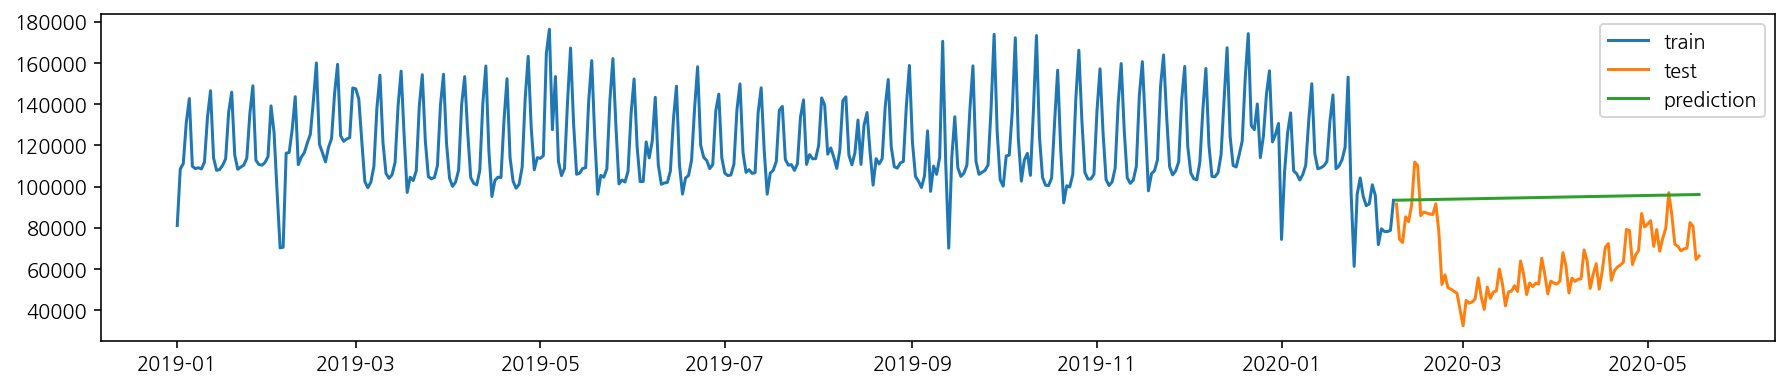

In [ ]:
print("Mean value of 고속터미널 : ", df_set.승하차인원.mean())
print("MAE Score of test :", mae(test.승하차인원, holt_pred))

plot_train_test_pred_graph(train, test, holt_pred)